### **Strategy 1: Employing a Frozen Layer Vector of ChemBERTa and PubMed as additional features** 
Goal is to predict drug-drug interactions for different relationship types based on the drug features. The features include information about individual drug side effects(mono side effects) and drug-protein interactions.

1. Features (X): Features are represented by drug_feat, which is a concatenation of the PCA-transformed (mono) and frozen embeddings from ChemBERTa as features in a deep neural network (DNN). 
- drug-label features based on PCA transformed mono side effects 10,184. Binary matrix where each row represents the a drug and column is mono side effecs 

2. Target (Y): Targets are represented by train_label_org, val_label_org, and test_label_org.
- For each drug-drug relationship type (out of the n_drugdrug_rel_types types), the target is binary and indicates whether there is an interaction (1) or not (0) between the drugs for that specific relationship type.

****

In [1]:
pip install azure-ai-ml azure-identity azureml-fsspec mltable scikit-learn matplotlib tensorflow==2.12.0 keras torch transformers scikit-learn keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [1]:
from __future__ import division
from __future__ import print_function
from operator import itemgetter
from itertools import combinations
from IPython.display import display, HTML
import time
import os
from collections import Counter
from collections import defaultdict
from scipy.stats import ks_2samp
import numpy as np
import random
import pandas as pd
import networkx as nx
import scipy.sparse as sp
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.layers import Dropout, Activation
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import mltable

ml_client = MLClient.from_config(credential=DefaultAzureCredential())

def load_data_from_azureml(ml_client, data_asset_name, version="1"):
    data_asset = ml_client.data.get(data_asset_name, version=version)
    path = {"folder": data_asset.path}
    tbl = mltable.from_delimited_files(paths=[path])
    return tbl.to_pandas_dataframe()

combo_df = load_data_from_azureml(ml_client, "bio-decagon-combo")
mono_df = load_data_from_azureml(ml_client, "bio-decagon-mono")
targets_all_df = load_data_from_azureml(ml_client, "bio-decagon-targets-all")

data_asset = ml_client.data.get("polypharmacycorpus", version="cleaned2024.03.29.211043")
polypharmacycorpus = pd.read_csv(data_asset.path)

data_asset = ml_client.data.get("645-Stitch-drugs-to-smiles", version="cleaned2024.07.08.002203")
smiles_df = pd.read_csv(data_asset.path)
smiles_df

2025-05-14 23:22:49.479476: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 23:22:49.854177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 23:22:51.438058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 23:22:51.441892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 23:22:54.995382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Resolving access token for scope "https://storage.azure.com/.default" using identity of type "MANAGED".
Getting data access token with Assigned Identity (client_id=clientid) and endpoint type based on configuration


STITCH                                             SMILES
0    CID000002173  CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...
1    CID000003345       CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3
2    CID000005206                           C(OC(C(F)(F)F)C(F)(F)F)F
3    CID000009433  CN1C2=C(C(=O)N(C1=O)C)NC=N2.CN1C2=C(C(=O)N(C1=...
4    CID000003929      CC(=O)NCC1CN(C(=O)O1)C2=CC(=C(C=C2)N3CCOCC3)F
..            ...                                                ...
640  CID003086258  CCC1=C2C=C3C(=C(C(=CC4=NC(=CC5=NC(=CC(=C1C)N2)...
641  CID009571074  CC1=C(SC=N1)C=CC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4...
642  CID000004011              CNCCCC12CCC(C3=CC=CC=C31)C4=CC=CC=C24
643  CID000002182                C1C2=C(C=CC(=C2Cl)Cl)N=C3N1CC(=O)N3
644  CID000005482    C1=CC(=C(C=C1Cl)Cl)C(CN2C=CN=C2)OCC3=C(SC=C3)Cl

[645 rows x 2 columns]

In [2]:
targets_all_df

STITCH   Gene
0       CID000060752   3757
1       CID006918155   2908
2       CID103052762   3359
3       CID023668479   1230
4       CID000028864   1269
...              ...    ...
131029  CID000092721   3426
131030  CID000092721   8858
131031  CID000092721  10942
131032  CID100115355   3242
131033  CID100115355  84842

[131034 rows x 2 columns]

In [3]:
mono_df

STITCH Individual Side Effect  \
0       CID003062316               C1096328   
1       CID003062316               C0162830   
2       CID003062316               C1611725   
3       CID003062316               C0541767   
4       CID003062316               C0242973   
...              ...                    ...   
174972  CID005282226               C1096278   
174973  CID005282226               C0272412   
174974  CID005282226               C0860013   
174975  CID005282226               C0853225   
174976  CID005282226               C1112371   

                                Side Effect Name  
0                    central nervous system mass  
1                      Photosensitivity reaction  
2                   leukaemic infiltration brain  
3                 platelet adhesiveness abnormal  
4                        Ventricular dysfunction  
...                                          ...  
174972             anterior chamber inflammation  
174973                           splenic abscess  
174974             hepatitis b antibody positive  
174975  international normalised ratio increased  
174976             Anterior chamber pigmentation  

[174977 rows x 3 columns]

In [4]:
polypharmacycorpus

STITCH 1 STITCH NAME_x      STITCH 2 STITCH NAME_y  \
0        CID000002173    ampicillin  CID000003345      fentanyl   
1        CID000002173    ampicillin  CID000003345      fentanyl   
2        CID000002173    ampicillin  CID000003345      fentanyl   
3        CID000002173    ampicillin  CID000003345      fentanyl   
4        CID000002173    ampicillin  CID000003345      fentanyl   
...               ...           ...           ...           ...   
4576780  CID000003461   gemcitabine  CID000003954    loperamide   
4576781  CID000003461   gemcitabine  CID000003954    loperamide   
4576782  CID000003461   gemcitabine  CID000003954    loperamide   
4576783  CID000003461   gemcitabine  CID000003954    loperamide   
4576784  CID000003461   gemcitabine  CID000003954    loperamide   

        Polypharmacy Side Effect      Side Effect Name  \
0                       C0004144           atelectasis   
1                       C0004604             back ache   
2                       C0034063            lung edema   
3                       C0085631              agitated   
4                       C0013384    abnormal movements   
...                          ...                   ...   
4576780                 C0149871  deep vein thromboses   
4576781                 C0035410        rhabdomyolysis   
4576782                 C0043096        loss of weight   
4576783                 C0003962               ascites   
4576784                 C0038999               bulging   

                      Disease Class  
0                               NaN  
1                               NaN  
2        respiratory system disease  
3                               NaN  
4                               NaN  
...                             ...  
4576780                         NaN  
4576781                         NaN  
4576782                         NaN  
4576783                         NaN  
4576784                         NaN  

[4576785 rows x 7 columns]

In [5]:
#----------------------------------------------------------------------------
# Returns dictionary from combination ID to pair of stitch IDs, 
# dictionary from combination ID to list of polypharmacy side effects, 
# and dictionary from side effects to their names.
from collections import defaultdict

def load_combo_se(df):
    combo2stitch = {}
    combo2se = defaultdict(set)
    se2name = {}

    for index, row in df.iterrows():
        stitch_id1 = row["STITCH 1"]
        stitch_id2 = row["STITCH 2"]
        se = row["Polypharmacy Side Effect"]
        se_name = row["Side Effect Name"]

        combo = stitch_id1 + "_" + stitch_id2
        combo2stitch[combo] = [stitch_id1, stitch_id2]
        combo2se[combo].add(se)
        se2name[se] = se_name

    n_interactions = sum([len(v) for v in combo2se.values()])
    print("Drug combinations: %d Side effects: %d" % (len(combo2stitch), len(se2name)))
    print("Drug-drug interactions: %d" % (n_interactions))

    return combo2stitch, combo2se, se2name

#Load data
combo2stitch, combo2se, se2name = load_combo_se(combo_df)

def load_mono_se(df):
    stitch2se = defaultdict(set)
    se2name = {}

    for index, row in df.iterrows():
        stitch_id = row["STITCH"]
        se = row["Individual Side Effect"]
        se_name = row["Side Effect Name"]
        
        stitch2se[stitch_id].add(se)
        se2name[se] = se_name

    return stitch2se, se2name

stitch2se, se2name_mono = load_mono_se(mono_df)

Drug combinations: 63473 Side effects: 1317
Drug-drug interactions: 4649441


In [6]:
def load_targets(df):
    stitch2proteins_all = defaultdict(set)

    for index, row in df.iterrows():
        stitch_id = row["STITCH"]
        gene = row["Gene"]
        stitch2proteins_all[stitch_id].add(gene)
    return stitch2proteins_all

stitch2proteins_all = load_targets(targets_all_df)

In [7]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype("int")
#----------------------------------------------------------------------------
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [8]:
# common side effects in drug combinations
def get_se_counter(se_map):
    side_effects = []
    for drug in se_map:
        side_effects += list(set(se_map[drug]))
    return Counter(side_effects)
combo_counter = get_se_counter(combo2se)
print("Most common side effects in drug combinations:")
common_se = []
common_se_counts = []
common_se_names = []
for se, count in combo_counter.most_common(964):
    common_se += [se]
    common_se_counts += [count]
    common_se_names += [se2name[se]]
df = pd.DataFrame(data={"Side Effect": common_se, "Frequency in Drug Combos": common_se_counts, "Name": common_se_names})  
display(df)

Most common side effects in drug combinations:


Side Effect  Frequency in Drug Combos  \
0      C0020649                     28568   
1      C0002871                     27006   
2      C0013404                     26037   
3      C0027497                     25190   
4      C0032285                     24430   
..          ...                       ...   
959    C0035220                       507   
960    C0021099                       507   
961    C0009326                       504   
962    C1261473                       502   
963    C0221247                       498   

                                       Name  
0           arterial pressure NOS decreased  
1                                   anaemia  
2                      Difficulty breathing  
3                                    nausea  
4                                  neumonia  
..                                      ...  
959  neonatal respiratory distress syndrome  
960                                impetigo  
961                        Collagen disease  
962                                 sarcoma  
963                      avascular necrosis  

[964 rows x 3 columns]

In [9]:
#---------------------------------------------------------------------------
val_test_size=0.05 #5% for validation and 5% 
n_drugs=645
n_proteins=8934
n_drugdrug_rel_types=964
#---------------------------------------------------------------------------
#list of drugs 
# lst: list of unique drug names from combo2stitch
lst=[]
for key , value in combo2stitch.items():
  first_name, second_name = map(lambda x: x.strip(), key.split("_"))
  if first_name not in lst:
    lst.append(first_name)
  if second_name not in lst:
    lst.append(second_name)
#---------------------------------------------------------------------------
#list of proteins
# p: list of unique proteins
p=[]
for k,v in stitch2proteins_all.items():
    for i in v:
        if i not in p:
            p.append(i)
#---------------------------------------------------------------------------
#construct drug-protein-adj matrix
# matrix  n_drugs x n_proteins
drug_protein_adj=np.zeros((n_drugs,n_proteins))
for i in range(n_drugs):
    for j in stitch2proteins_all[lst[i]]:
        k=p.index(j)
        drug_protein_adj[i,k]=1
#---------------------------------------------------------------------------
#construct drug-drug-adj matrices for all side effects
# 
drug_drug_adj_list=[]
l=[]
for i in range(n_drugdrug_rel_types):
  print(i)
  mat = np.zeros((n_drugs, n_drugs))
  l.append(df.at[i,"Side Effect"])
  for se in l:
    print(se)
    for d1, d2 in combinations(list(range(n_drugs)), 2):
      if lst[d1]+"_"+lst[d2]  in combo2se:
        if se in combo2se[lst[d1]+"_"+lst[d2]]:
            mat[d1,d2]=mat[d2,d1]=1
  l=[]
  drug_drug_adj_list.append(mat)
drug_degrees_list = [np.array(drug_adj.sum(axis=0)).squeeze() for drug_adj in drug_drug_adj_list]
#-------------------------------------------------------------------------
#select drug pairs for training & validation & testing
# edges: List of positive drug pairs for each relationship type
# edges_false: list of negative drug pairs
# edges_all: shuffled list of positive and negative drug pairs 
edges=[]
for k in range(n_drugdrug_rel_types):
    l=[]
    for i in range(n_drugs):
        for j in range(n_drugs):
            if drug_drug_adj_list[k][i,j]==1:
                l.append([i,j])
    edges.append(l)
edges_false=[]
for k in range(n_drugdrug_rel_types):
    l=[]
    for i in range(n_drugs):
        for j in range(n_drugs):
            if drug_drug_adj_list[k][i,j]==0:
                l.append([i,j])
    edges_false.append(l)
for k in range(n_drugdrug_rel_types):
    np.random.shuffle(edges[k])
    np.random.shuffle(edges_false[k])
for k in range(n_drugdrug_rel_types):
    a=len(edges[k])
    edges_false[k]=edges_false[k][:a]
edges_all=[]
for k in range(n_drugdrug_rel_types):
    edges_all.append(edges[k]+edges_false[k])
for k in range(n_drugdrug_rel_types):
    np.random.shuffle(edges_all[k])
for k in range(n_drugdrug_rel_types):
    a=len(edges[k])
    edges_all[k]=edges_all[k][:a]
val=[]
test=[]
train=[]
for k in range(n_drugdrug_rel_types):
    a=int(np.floor(len(edges_all[k])*val_test_size))
    val.append(edges_all[k][:a])
    test.append(edges_all[k][a:a+a])
    train.append(edges_all[k][a+a:])
    

0
C0020649
1
C0002871
2
C0013404
3
C0027497
4
C0032285
5
C0015672
6
C0030193
7
C0011991
8
C0004093
9
C0042963
10
C0085649
11
C0015967
12
C0008033
13
C0000737
14
C0398353
15
C0008031
16
C0012833
17
C0004604
18
C0018681
19
C0020538
20
C0009676
21
C0011175
22
C0003467
23
C0035078
24
C0043096
25
C0020456
26
C0013604
27
C0003123
28
C0003862
29
C0022660
30
C0442874
31
C0030196
32
C0042029
33
C0010200
34
C0009806
35
C0039231
36
C0043094
37
C0040034
38
C0032227
39
C0243026
40
C0018802
41
C0027051
42
C1145670
43
C0004238
44
C0013144
45
C0015230
46
C0917801
47
C0037763
48
C0038454
49
C0027947
50
C0020625
51
C0231218
52
C0040822
53
C0011168
54
C0007642
55
C0027404
56
C0041657
57
C0085631
58
C0019080
59
C0017168
60
C0002622
61
C0020443
62
C0575081
63
C0085593
64
C0039070
65
C0036572
66
C0006277
67
C0041834
68
C0010054
69
C0020458
70
C0344232
71
C0033774
72
C0497247
73
C0021311
74
C0232492
75
C0013395
76
C0030554
77
C0151904
78
C0037199
79
C0011615
80
C0011849
81
C0020621
82
C0231528
83
C0030312
84

In [10]:
drug_info_dict = {}

for drug_id in lst:
    matching_rows = polypharmacycorpus[polypharmacycorpus["STITCH 1"] == drug_id]
    if not matching_rows.empty:
        stitch_name_x = matching_rows.iloc[0]["STITCH NAME_x"]
        drug_info_dict[drug_id] = stitch_name_x
    else:
        matching_rows = polypharmacycorpus[polypharmacycorpus["STITCH 2"] == drug_id]
        if not matching_rows.empty:
            stitch_name_y = matching_rows.iloc[0]["STITCH NAME_y"]
            drug_info_dict[drug_id] = stitch_name_y
        else:
            # Handle the case where no matching row is found for the drug_id in both columns
            drug_info_dict[drug_id] = "Name not found"

print(len(drug_info_dict))

drug_info_dict["CID000004635"]

645


'oxycodone'

In [11]:
drug_info_dict["CID000004635"]

'oxycodone'

##### PubChem API

In [16]:
# import requests

# def get_smiles(drug_id):
#     try:
#         # Use the PubChem API to search for the compound by name and retrieve its Canonical SMILES
#         url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{(drug_id)}/property/CanonicalSMILES/JSON"
#         response = requests.get(url)
#         if response.status_code == 200:
#             data = response.json()
#             smiles = data["PropertyTable"]["Properties"][0]["CanonicalSMILES"]
#             return smiles
#         else:
#             return ""
#     except Exception as e:
#         return f"Error: {str(e)}"

# drug_smiles_dict = drug_info_dict.copy()

# for key, value in drug_smiles_dict.items():
#     drug_smiles_dict[key] = get_smiles(value)


##### **Validate SMILES dict drug_id_to_smiles based on position of lst (drugs)**

In [14]:
# drug_id_to_smiles = {}

# for drug_id in lst:
#     smiles_string = drug_smiles_dict.get(drug_id, "")
#     drug_id_to_smiles[drug_id] = smiles_string
# drug_id_to_smiles

# check 
# drug_id_to_smiles["CID000002130"]

##### **Updating Missing SMILES:**

In [15]:
# missing_smiles_drug_ids = [drug_id for drug_id, smiles in drug_id_to_smiles.items() if smiles == ""]

# print("Drug IDs with missing Canonical SMILES SMILES:", missing_smiles_drug_ids)
# print(len(missing_smiles_drug_ids))

In [16]:
# smiles_update = {
#     "CID000041774": "CC1C(C(C(C(O1)OC2C(OC(C(C2O)O)OC3C(OC(C(C3O)O)O)CO)CO)O)O)NC4C=C(C(C(C4O)O)O)CO",
#     "CID000000596": "C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O",
#     "CID000004411": "CC(C)(C)NCC(COC1=CC=CC2=C1CC(C(C2)O)O)O",
#     "CID000083786": "C1=NNC2=C1NC=NC2=O",
#     "CID000000838": "CNCC(C1=CC(=C(C=C1)O)O)O",
#     "CID000001986": "CC(=O)NC1=NN=C(S1)S(=O)(=O)N",
#     "CID000004112": "CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C(=O)NC(CCC(=O)O)C(=O)O",
#     "CID000005039": "CNC(=C[N+](=O)[O-])NCCSCC1=CC=C(O1)CN(C)C",
#     "CID000003559": "C1CN(CCC1(C2=CC=C(C=C2)Cl)O)CCCC(=O)C3=CC=C(C=C3)F", 
#     "CID000004909": "CCC1(C(=O)NCNC1=O)C2=CC=CC=C2",
#     "CID000038904": "C1CC(C1)(C(=O)O)C(=O)O.N.N.[Pt]",
#     "CID005281007": "CN(C)NN=C1C(=NC=N1)C(=O)N", 
#     "CID000004485": "CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2[N+](=O)[O-])C(=O)OC",
#     "CID000005651": "CC1C(C(CC(O1)OC2C(C(C(OC2OC3=C4C=C5C=C3OC6=C(C=C(C=C6)C(C(C(=O)NC(C(=O)NC5C(=O)NC7C8=CC(=C(C=C8)O)C9=C(C=C(C=C9O)O)C(NC(=O)C(C(C1=CC(=C(O4)C=C1)Cl)O)NC7=O)C(=O)O)CC(=O)N)NC(=O)C(CC(C)C)NC)O)Cl)CO)O)O)(C)N)O",
#     "CID000002405": "CC(C)NCC(COC1=CC=C(C=C1)COCCOC(C)C)O",
#     "CID000003016": "CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3", 
#     "CID000002576": "CCCC(C)(COC(=O)N)COC(=O)NC(C)C", 
#     "CID000060835": "CNCCC(C1=CC=CS1)OC2=CC=CC3=CC=CC=C32",
#     "CID000003657": "C(=O)(N)NO", 
#     "CID000005358": "CNS(=O)(=O)CC1=CC2=C(C=C1)NC=C2CCN(C)C", 
#     "CID000004894": "CC12CC(C3C(C1CCC2(C(=O)CO)O)CCC4=CC(=O)C=CC34C)O", 
#     "CID000005234": "[,+].[Cl-]",
#     "CID000002578": "C(CCl)NC(=O)N(CCCl)N=O",
#     "CID000003152": "COC1=C(C=C2C(=C1)CC(C2=O)CC3CCN(CC3)CC4=CC=CC=C4)OC", 
#     "CID000027686": "C1=CC2=C(C(=C1)OCC(COC3=CC4=C(C=C3)OC(=CC4=O)C(=O)O)O)C(=O)C=C(O2)C(=O)O", 
#     "CID000003154": "CCNC1CC(S(=O)(=O)C2=C1C=C(S2)S(=O)(=O)N)C", 
#     "CID000000772": "CC(=O)NC1C(C(C(OC1O)COS(=O)(=O)O)OC2C(C(C(C(O2)C(=O)O)OC3C(C(C(C(O3)CO)OC4C(C(C(C(O4)C(=O)O)O)O)OS(=O)(=O)O)OS(=O)(=O)O)NS(=O)(=O)O)O)OS(=O)(=O)O)O", 
#     "CID000003661": "CN1C2CCC1CC(C2)OC(=O)C(CO)C3=CC=CC=C3",
#     "CID000004419": "C1CC(C1)CN2CCC34C5C(CCC3(C2CC6=C4C(=C(C=C6)O)O5)O)O", 
#     "CID000003516": "COC1=CC=CC=C1OCC(CO)O",
#     "CID000003404": "COCCCCC(=NOCCN)C1=CC=C(C=C1)C(F)(F)F", 
#     "CID000005077": "CCN(C)C(=O)OC1=CC=CC(=C1)C(C)N(C)C", 
#     "CID000005095": "CCCN(CCC)CCC1=C2CC(=O)NC2=CC=C1",
#     "CID000004058": "CCOC(=O)C1(CCN(CC1)C)C2=CC=CC=C2",
#     "CID000160051": "CCCCCCCCCCNCC=C.C[N+](C)(C)CCCCCCNCC=C.C=CCN.C1C(O1)CCl.Cl.[Cl-]", 
#     "CID000443871": "CC(C)C1CCCC(C1)C(=O)NC(CC2=CC=CC=C2)C(=O)O", 
#     "CID000002800": "CCN(CC)CCOC1=CC=C(C=C1)C(=C(C2=CC=CC=C2)Cl)C3=CC=CC=C3", 
#     "CID000003463": "CC1=CC(=C(C=C1)C)OCCCC(C)(C)C(=O)O", 
#     "CID000004583": "CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(=O)O", 
#     "CID000000598": "C(CS(=O)(=O)O)S", 
#     "CID000060198": "CC12CCC3C(C1CCC2=O)CC(=C)C4=CC(=O)C=CC34C", 
#     "CID000005195": "CC(CC1=CC=CC=C1)N(C)CC#C",
#     "CID000005152": "C1=CC=C(C=C1)CCCCOCCCCCCNCC(C2=CC(=C(C=C2)O)CO)O", 
#     "CID000003305": "CC(O)(P(=O)(O)O)P(=O)(O)O", 
#     "CID000003403": "CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)O)O)O)C3=CC=C(C=C3)F", 
#     "CID000005746": "CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N", 
#     "CID000153941": "C=C1C(CC(C1CO)O)N2C=NC3=C2NC(=NC3=O)N", 
#     "CID000003869": "CC(CCC1=CC=CC=C1)NCC(C2=CC(=C(C=C2)O)C(=O)N)O", 
#     "CID000005372": "CC1CC(C2C(CC(C(O2)(C(=O)C(=O)N3CCCCC3C(=O)OC(C(C(CC(=O)C(C=C(C1)C)CC=C)O)C)C(=CC4CCC(C(C4)OC)O)C)O)C)OC)OC",
#     "CID000004991": "C[N+]1=CC=CC(=C1)OC(=O)N(C)C", 
#     "CID000002712": "CN=C1CN(C(=C2C=C(C=CC2=N1)Cl)C3=CC=CC=C3)O", 
#     "CID000002713": "C1=CC(=CC=C1NC(=NC(=NCCCCCCN=C(N)N=C(N)NC2=CC=C(C=C2)Cl)N)N)Cl", 
#     "CID000657298": "CCCC1=CC(=O)NC(=S)N1", 
#     "CID000002801": "CN(C)CCCN1C2=CC=CC=C2CCC3=C1C=C(C=C3)Cl",
#     "CID000054547": "COCC1=C(N2C(C(C2=O)NC(=O)C(=NOC)C3=CSC(=N3)N)SC1)C(=O)O", 
#     "CID005487301": "CCCCCN=C(N)NNC=C1C=NC2=C1C=C(C=C2)CO", 
#     "CID000003148": "C1C2CC3CC(CC1N3CC2=O)OC(=O)C4=CNC5=CC=CC=C54",
#     "CID000001775": "C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3",
#     "CID000003767": "C1=CN=CC=C1C(=O)NN", 
#     "CID000000861": "C1=CC(=C(C=C1OC2=C(C=C(C=C2I)CC(C(=O)O)N)I)I)O",
#     "CID000002462": "CCCC1OC2CC3C4CCC5=CC(=O)C=CC5(C4C(CC3(C2(O1)C(=O)CO)C)O)C",
#     "CID000003488": "COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3", 
#     "CID003002190": "CC[C@@H]1[C@@]2([C@@H]([C@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H](C(=O)[C@H](C(=O)O1)C)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)OC)C)C)N(C(=O)O2)CCCCN4C=C(N=C4)C5=CN=CC=C5)C", 
#     "CID000003249": "CC(C)C(C)C=CC(C)C1CCC2C1(CCCC2=CC=C3CC(CCC3=C)O)C",
#     "CID000003379": "CC1(OC2CC3C4CC(C5=CC(=O)C=CC5(C4C(CC3(C2(O1)C(=O)CO)C)O)C)F)C", 
#     "CID000005408": "CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C", 
#     "CID000002895": "CN(C)CCC=C1C2=CC=CC=C2C=CC3=CC=CC=C31",
#     "CID000008953": "C(=O)(O)[O-].[Na+]", 
#     "CID000005401": "COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CCCO4)N)OC", 
#     "CID000001071": "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CCO)C)C",
#     "CID000004513": "CNC(=C[N+](=O)[O-])NCCSCC1=CSC(=N1)CN(C)C",
#     "CID000016231": "C1(=C(N=C(C(=N1)Cl)N)N)C(=O)N=C(N)N", 
#     "CID000004236": "C1=CC=C(C=C1)C(C2=CC=CC=C2)S(=O)CC(=O)N", 
#     "CID005362420": "CC1=C(C2=CC3=NC(=CC4=C(C(=C(N4)C=C5C6(C(C(=CC=C6C(=N5)C=C1N2)C(=O)OC)C(=O)OC)C)C)CCC(=O)OC)C(=C3C)CCC(=O)O)C=C", 
#     "CID000009052": "CC(=O)CC(C1=CC=C(C=C1)[N+](=O)[O-])C2=C(OC3=CC=CC=C3C2=O)O", 
#     "CID000002269": "CCC1C(C(C(N(CC(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(C(O2)C)O)(C)OC)C)OC3C(C(CC(O3)C)N(C)C)O)(C)O)C)C)C)O)(C)O", 
#     "CID000005472": "C1CN(CC2=C1SC=C2)CC3=CC=CC=C3Cl", 
#     "CID000005771": "CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(CSSCC(C(=O)NC(C(=O)N1)CC2=CC=C(C=C2)O)N)C(=O)N3CCCC3C(=O)NC(CC(C)C)C(=O)NCC(=O)N)CC(=O)N)CCC(=O)N", 
#     "CID000004993": "CCC1=C(C(=NC(=N1)N)N)C2=CC=C(C=C2)Cl", 
#     "CID000054786": "CCCCCC(CCC1C(CC2C1CC3=C(C2)C(=CC=C3)OCC(=O)O)O)O", 
#     "CID000000564": "C(CCC(=O)O)CCN", 
#     "CID000176168": "C(=O)([O-])[O-].C(=O)([O-])[O-].C(=O)([O-])[O-].O.[La+3].[La+3]", 
#     "CID000024011": "S=[Se]",
#     "CID000004834": "CCN1CCN(C(=O)C1=O)C(=O)NC(C2=CC=CC=C2)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)[O-]",
#     "CID000003059": "C1=CC(=C(C=C1C2=C(C=C(C=C2)F)F)C(=O)O)O", 
#     "CID000003821": "CNC1(CCCCC1=O)C2=CC=CC=C2Cl",
#     "CID000005352": "CC1=C(C2=C(C1=CC3=CC=C(C=C3)S(=O)C)C=CC(=C2)F)CC(=O)O", 
#     "CID000197712": "CC1=CC(=NC(=N1)OC(C(=O)O)C(C2=CC=CC=C2)(C3=CC=CC=C3)OC)C", 
#     "CID000060164": "COC1=C(C=C(C=C1)C2=CC3=C(C=C2)C=C(C=C3)C(=O)O)C45CC6CC(C4)CC(C6)C5", 
#     "CID006436173": "CC1C=CC=C(C(=O)NC2=C(C3=C(C4=C(C(=C3O)C)OC(C4=O)(OC=CC(C(C(C(C(C(C1O)C)O)C)OC(=O)C)C)OC)C)C5=C2N6C=CC(=CC6=N5)C)O)C", 
#     "CID000060612": "CC1=C(C(=CC=C1)C(C)C2=CN=CN2)C",
#     "CID000003964": "CN1CCN(CC1)C2=NC3=CC=CC=C3OC4=C2C=C(C=C4)Cl", 
#     "CID000003494": "C[N+]1(CCC(C1)OC(=O)C(C2CCCC2)(C3=CC=CC=C3)O)C", 
#     "CID000002349": "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C",
#     "CID000002283": "CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N1)CCCN)CCCCNC(=O)C(C(C)CC)NC(=O)C(CCC(=O)O)NC(=O)C(CC(C)C)NC(=O)C2CSC(=N2)C(C(C)CC)N)CC(=O)N)CC(=O)O)CC3=CN=CN3)CC4=CC=CC=C4", 
#     "CID000003637": "C1=CC=C2C(=C1)C=NN=C2NN", 
#     "CID000072938": "CON=C1CN(CC1CN)C2=C(C=C3C(=O)C(=CN(C3=N2)C4CC4)C(=O)O)F", 
#     "CID003086258": "CCC1=C2C=C3C(=C(C(=CC4=NC(=CC5=NC(=CC(=C1C)N2)C(=C5CCC(=O)O)C)C(=C4C)CCC(=O)O)N3)C(C)O)C",
#     "CID009571074": "CC1=C(SC=N1)C=CC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4=CSC(=N4)N)SC2)C(=O)O"
# }

In [17]:
# for drug_id, smiles in drug_id_to_smiles.items():
#     if smiles == "":
#         # Check if the missing drug_id is in the smiles_update dictionary
#         if drug_id in smiles_update:
#             # Update the SMILES string in drug_id_to_smiles
#             drug_id_to_smiles[drug_id] = smiles_update[drug_id]

In [18]:
# missing_smiles_drug_ids = [drug_id for drug_id, smiles in drug_id_to_smiles.items() if smiles == ""]
# print(len(missing_smiles_drug_ids))

# drug_id_to_smiles

##### Save as df

In [19]:
# smiles_df = pd.DataFrame(list(drug_id_to_smiles.items()), columns=['STITCH', 'SMILES'])

In [20]:
# from azure.ai.ml.entities import Data
# from azure.ai.ml.constants import AssetTypes
# import time
# import pandas as pd
# from azureml.core import Workspace, Datastore

# workspace = Workspace.from_config()
# default_datastore = workspace.get_default_datastore()
# csv_file_path = "645_Stitch_drugs_to_smiles.csv"
# smiles_df.to_csv(csv_file_path, index=False)

# # Upload the CSV file to the root of the Datastore
# default_datastore.upload_files([csv_file_path], target_path=".", overwrite=True, show_progress=True)

# # Create a new version of the data asset
# v2 = "cleaned" + time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())
# my_path = f"./{csv_file_path}"

# # Define the data asset, and use tags to make it clear the asset can be used in training
# my_data = Data(
#     name="645-Stitch-drugs-to-smiles",
#     version=v2,
#     description="645_Stitch_drugs_to_smiles",
#     tags={"training_data": "true", "format": "csv"},
#     path=my_path,
#     type=AssetTypes.URI_FILE,
# )

# # Create or update the data asset
# my_data = ml_client.data.create_or_update(my_data)

# print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

**Mapping Drug to SMILES**

Incorporated SMILES chemical string for 645 unique drugs

In [12]:
drug_id_to_smiles = {}

for drug_id in lst:
    smiles_string = smiles_df.loc[smiles_df["STITCH"] == drug_id, 'SMILES'].values[0]
    drug_id_to_smiles[drug_id] = smiles_string
    
drug_id_to_smiles
len(drug_id_to_smiles)

645

In [18]:
# drug_id_to_smiles["CID000003345"]
drug_id_to_smiles["CID000004635"] # oxycodone

'CN1CCC23C4C(=O)CCC2(C1CC5=C3C(=C(C=C5)OC)O4)O'

### Model Training Strategies 



#### Strategy 1: Frozen Layer Vector of ChemBERTa
https://huggingface.co/DeepChem/ChemBERTa-77M-MLM (Developed by DeepChem/ChemBERTa-77M-MLM Transformer Encoder model trained on a large corpus of molecular data 77M molecules)
* DeepChem/ChemBERTa-77M-MLM: Trained using masked language modeling, where parts of the input are masked and the model learns to predict the masked parts.
* DeepChem/ChemBERTa-77M-MTR: Training Objective: Trained to generate textual descriptions from molecular structures; tasks that require translating molecular structures into textual descriptions

**Step 1: Generate ChemBERTa Features for Each Drug (645 unique drugs) **

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch
# uses Byte-Pair Encoding (BPE), such as WordPiece or SentencePiece https://deepchem.readthedocs.io/en/2.4.0/api_reference/tokenizers.html
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
tokenizer_config = tokenizer.init_kwargs

# tokenizer type
print(f"Tokenizer Type: {tokenizer.__class__.__name__}")
print(f"Tokenizer Configuration: {tokenizer_config}")
print(f"Sample Vocabulary Tokens: {list(tokenizer.get_vocab().keys())[:100]}")

# tokenizer converts SMILES strings to token IDs.
model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
# Example SMILES string for Oxycodone
smiles_oxycodone = "CN1CCC23C4C(=O)CCC2(C1CC5=C3C(=C(C=C5)OC)O4)O"

# Tokenize the SMILES string
tokens = tokenizer.tokenize(smiles_oxycodone)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

Tokens: ['C', 'N', '1', 'C', 'C', 'C', '2', '3', 'C', '4', 'C', '(', '=', 'O', ')', 'C', 'C', 'C', '2', '(', 'C', '1', 'C', 'C', '5', '=', 'C', '3', 'C', '(', '=', 'C', '(', 'C', '=', 'C', '5', ')', 'O', 'C', ')', 'O', '4', ')', 'O']
Token IDs: [16, 23, 20, 16, 16, 16, 21, 26, 16, 32, 16, 17, 22, 19, 18, 16, 16, 16, 21, 17, 16, 20, 16, 16, 43, 22, 16, 26, 16, 17, 22, 16, 17, 16, 22, 16, 43, 18, 19, 16, 18, 19, 32, 18, 19]


In [20]:
from transformers import AutoTokenizer, AutoModel
import torch
# uses Byte-Pair Encoding (BPE), such as WordPiece or SentencePiece https://deepchem.readthedocs.io/en/2.4.0/api_reference/tokenizers.html
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
tokenizer_config = tokenizer.init_kwargs

# tokenizer type
print(f"Tokenizer Type: {tokenizer.__class__.__name__}")
print(f"Tokenizer Configuration: {tokenizer_config}")
print(f"Sample Vocabulary Tokens: {list(tokenizer.get_vocab().keys())[:100]}")

# tokenizer converts SMILES strings to token IDs.
model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
# https://huggingface.co/DeepChem/ChemBERTa-10M-MLM/tree/main


# Another model is available in Hugging Face 
# from transformers import AutoTokenizer, RobertaForRegression
# tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
# model = RobertaForRegression.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

# Another model 
# https://huggingface.co/DeepChem/ChemBERTa-77M-MTR

for param in model.parameters():
    param.requires_grad = False

print("Model Layers:")
for i, layer in enumerate(model.encoder.layer):
    print(f"Layer {i}: {layer}")

print("\nModel Parameters:")
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, shape: {param.shape}")
# print(model.summary())
print("The hidden size (vector size) of the model is:", model.config.hidden_size) # 384 is vector size 

# ChemBerta model is frozen, weights are not updated only to extract features.  
# Extracts the first token from the last hidden state, which serves as a fixed-size feature vector.

def get_chemberta_features(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    features = outputs.last_hidden_state[:, 0, :].squeeze() # extracting the last_hidden_state layer (final encoder layer)
    # output fixed size feature vector 384, output of the final encoder layer in the transformer model encoder.layer.2 (index sarts from 0)
    # It contains the embeddings for each token in the input sequence after processing through all layers of the transformer model
    features = features.cpu().numpy()
    return features

# smiles = "CCC2"
# sample_chemberta_features = get_chemberta_features(smiles)
# print(len(sample_chemberta_features))
# print(sample_chemberta_features)

#  Store as dictionary where each drug ID maps to its corresponding ChemBERTa feature vector
chemberta_features = {drug_id: get_chemberta_features(smiles) for drug_id, smiles in drug_id_to_smiles.items()}

Model Layers:
Layer 0: RobertaLayer(
  (attention): RobertaAttention(
    (self): RobertaSdpaSelfAttention(
      (query): Linear(in_features=384, out_features=384, bias=True)
      (key): Linear(in_features=384, out_features=384, bias=True)
      (value): Linear(in_features=384, out_features=384, bias=True)
      (dropout): Dropout(p=0.109, inplace=False)
    )
    (output): RobertaSelfOutput(
      (dense): Linear(in_features=384, out_features=384, bias=True)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
  )
  (intermediate): RobertaIntermediate(
    (dense): Linear(in_features=384, out_features=464, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): RobertaOutput(
    (dense): Linear(in_features=464, out_features=384, bias=True)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.144, inplace=False)
  )
)
Layer 1: RobertaLayer(
  (attent

In [21]:
drug_info_dict["CID000002173"] #CID000002173  is 'ampicillin'

'ampicillin'

In [22]:
#print(drug_id_to_smiles) #{'CID000002173': 'CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)O)C',}
print(get_chemberta_features('CID000002173'))

[ 3.73807371e-01 -2.44110703e-01  1.56309843e-01 -9.85649414e-03
 -1.33801475e-01 -2.58392930e-01 -9.66650546e-02 -4.38521504e-02
 -8.38858187e-02 -1.37543753e-01 -3.89824629e-01  2.04127487e-02
 -1.21090204e-01 -2.20329523e-01 -1.17809132e-01 -7.01769516e-02
  4.67488617e-01  2.24954382e-01  2.60705173e-01 -3.57470840e-01
 -7.77135491e-02  3.09815884e-01  3.43021564e-02 -2.55163044e-01
 -3.24551612e-01 -4.06617336e-02 -5.25683224e-01 -1.95645079e-01
  5.78272529e-02 -2.63837874e-01 -2.84671426e-01  3.51098329e-01
  2.20582843e-01 -3.49855542e-01 -5.72957136e-02 -1.31479157e-02
 -3.28444429e-02  6.12315834e-02 -4.20783699e-01  4.42666084e-01
 -1.77857921e-01 -9.11463946e-02  1.12620361e-01  4.61517125e-01
  1.32573545e-01 -2.43066341e-01 -1.30062252e-01  8.66327807e-02
 -3.38686965e-02  8.37226510e-02 -1.84407264e-01 -2.05486223e-01
 -3.59606266e-01 -3.09385777e-01 -2.06315249e-01  3.47543120e-01
 -3.32752377e-01 -6.95801601e-02  1.91447824e-01 -5.70773557e-02
  1.46840304e-01  1.63526

Strategy 2: PubMed (Mono side effects) + ChemBERTa

In [24]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA


# smiles_df has columns ["STITCH", "SMILES"]
# se2name_mono = { side_effect_id: side_effect_text, ... }
# stitch2se = { drug_stitch_id: [side_effect_ids], ... }
# lst = [list of all STITCH drug IDs in order]
# n_drugs = 645

# 1) Prepare Mono side-effect list
se_mono = list(se2name_mono.keys())
print("Num unique side effects:", len(se_mono))

# 2) Load frozen PubMedBERT
tokenizer = AutoTokenizer.from_pretrained("neuml/pubmedbert-base-embeddings")
model = AutoModel.from_pretrained("neuml/pubmedbert-base-embeddings").eval()
for param in model.parameters():
    param.requires_grad = False

print("PubMedBERT hidden size:", model.config.hidden_size)

# Function to get [CLS] embeddings
def get_pubmedbert_features(sentence: str) -> np.ndarray:
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    vec = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return vec

# 3) Precompute side-effect embeddings
mono_pubmed_features = {
    mono_id: get_pubmedbert_features(se2name_mono[mono_id])
    for mono_id in se_mono
}
mono_pubmed_features_df = pd.DataFrame(
    list(mono_pubmed_features.items()), columns=['MonoSideEffects', 'PubMedBert']
)
print(mono_pubmed_features_df.head())

# 4) Mono Side effects Build (645×len(se_mono)) label matrix
drug_label = np.zeros((n_drugs, len(se_mono)), dtype=np.int32)
for drug_stitch_id, side_list in stitch2se.items():
    d_idx = lst.index(drug_stitch_id)
    for side_id in side_list:
        s_idx = se_mono.index(side_id)
        drug_label[d_idx, s_idx] = 1

print("drug_label shape:", drug_label.shape)

# 5) Convert side-effect dict to array for indexing
side_effect_emb_array = np.zeros((len(se_mono), 768), dtype=np.float32)
for i, side_id in enumerate(se_mono):
    side_effect_emb_array[i] = mono_pubmed_features[side_id]

# 6) Aggregate embeddings per drug
aggregated_side_effects = np.zeros((n_drugs, 768), dtype=np.float32)
for d_idx in range(n_drugs):
    present_indices = np.where(drug_label[d_idx] == 1)[0]
    if len(present_indices) > 0:
        aggregated_side_effects[d_idx] = side_effect_emb_array[present_indices].mean(axis=0)
    else:
        aggregated_side_effects[d_idx] = 0.0

print("aggregated_side_effects shape:", aggregated_side_effects.shape)

# 7) Optional PCA PubMed
pca = PCA(n_components=384)
pca.fit(aggregated_side_effects)
mono_side_effects_pubmedpca384 = pca.transform(aggregated_side_effects)
print("mono_side_effects_pubmedpca384 shape:", mono_side_effects_pubmedpca384.shape)

# 8) ChemBERTa matrix (645×384)
# chemberta_features: dict {drug_id -> (384D vector)}
chemberta_feature_matrix = np.array(
    [chemberta_features[drug_id] for drug_id in lst]
)


# Protein Feature Matrix is (645, 8934)
print("Shape of drug_protein_adj matrix:", drug_protein_adj.shape) # drug_protein_adj (645, 8934) dimensions before PCA
print("Size of the first row of drug_protein_adj matrix:", drug_protein_adj[0].size)  # 8934 

pca_= PCA(.95)
pca_.fit(drug_protein_adj)
drug_protein_pca = pca_.transform(drug_protein_adj) # (645, 22)
print("Shape of drug_protein_pca matrix:", drug_protein_pca.shape)
# drug_feat = np.concatenate((pca.transform(drug_label),pca_.transform(drug_protein_adj)),axis=1)

# Drug_feature Matrix with ChemBERTa Embeddings, PubMedBERT_pca, Protein_pca = Final 790-dim feature

# drug_feat = np.concatenate(
#     (chemberta_feature_matrix, mono_side_effects_pubmedpca384, drug_protein_pca),
#     axis=1
# )
drug_feat = np.concatenate(
    (chemberta_feature_matrix, mono_side_effects_pubmedpca384), axis=1
    )
print("drug_feat shape:", drug_feat.shape)
# drug_feat = np.concatenate(
#     (chemberta_feature_matrix, mono_side_effects_pubmedpca384),
#     axis=1
# )
# print("drug_feat shape:", drug_feat.shape)

# 9) Create (drug_index, SMILES) pairs for DistilGPT2
# training_data = []
# for i, row in smiles_df.iterrows():
#     stitch_id = row["STITCH"]
#     if stitch_id in lst:
#         d_idx = lst.index(stitch_id)
#         smiles_str = row["SMILES"]
#         training_data.append((d_idx, smiles_str))

# print("Example training_data:", training_data[:5])

PubMedBERT hidden size: 768
  MonoSideEffects                                         PubMedBert
0        C1096328  [0.09458755, 0.6171773, 0.70632243, -0.3478447...
1        C0162830  [-0.39038405, -0.8645706, -0.18166348, -0.4537...
2        C1611725  [-0.066645324, 0.46948126, 0.15650502, -0.3978...
3        C0541767  [0.035637118, 0.2466813, -0.14453568, -1.38041...
4        C0242973  [-0.8275162, 0.50826925, 0.77408427, -0.931636...
drug_label shape: (645, 10184)
aggregated_side_effects shape: (645, 768)
mono_side_effects_pubmedpca384 shape: (645, 384)
Shape of drug_protein_adj matrix: (645, 8934)
Size of the first row of drug_protein_adj matrix: 8934
Shape of drug_protein_pca matrix: (645, 22)
drug_feat shape: (645, 768)


In [ ]:
#------------------------------------------------------------------------
#construct train & validation & test sets
val_sets=[]
val_labels=[]
for k in range(n_drugdrug_rel_types):
    v=[]
    a=[]
    for  i in val[k]:
        v.append(drug_feat[i[0]]+drug_feat[i[1]])
        a.append(drug_drug_adj_list[k][i[0],i[1]])
    val_sets.append(v)
    val_labels.append(a)
test_sets=[]
test_labels=[]
for k in range(n_drugdrug_rel_types):
    te=[]
    a=[]
    for  i in test[k]:
        te.append(drug_feat[i[0]]+drug_feat[i[1]])
        a.append(drug_drug_adj_list[k][i[0],i[1]])
    test_sets.append(te)
    test_labels.append(a)
train_sets=[]
train_labels=[]
for k in range(n_drugdrug_rel_types):
    tr=[]
    a=[]
    for  i in train[k]:
        tr.append(drug_feat[i[0]]+drug_feat[i[1]])
        a.append(drug_drug_adj_list[k][i[0],i[1]])
    train_sets.append(tr)
    train_labels.append(a)
# constructs the training, validation, and test sets by combining features of drug pairs
val_org=[]
val_label_org=[]
test_org=[]
test_label_org=[]
train_org=[]
train_label_org=[]
for k in range(n_drugdrug_rel_types):
    val_org.append(np.array(val_sets[k]))
    val_label_org.append(np.array(val_labels[k]))
    test_org.append(np.array(test_sets[k]))
    test_label_org.append(np.array(test_labels[k]))
    train_org.append(np.array(train_sets[k]))
    train_label_org.append(np.array(train_labels[k]))

In [ ]:
print((val_org[0]))
print((val_label_org[0]))
print(len(test_org))
print(len(test_label_org))
print(len(train_org))
print(len(train_label_org))

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(250, input_dim=drug_feat.shape[1], kernel_initializer="glorot_normal"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))

model.add(Dense(300, kernel_initializer="glorot_normal"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))

model.add(Dense(200, kernel_initializer="glorot_normal"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))

model.add(Dense(1, kernel_initializer="glorot_normal", activation="sigmoid"))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np
import joblib

roc_score = []
aupr_score = []
f_score = []
thr = []
precision = []
recall = []
tpos = []
fpos = []
tneg = []
fneg = []
acc = []
mcc = []
performance_metrics = []
loss_values = []

# for overall ROC curve
all_fpr = []
all_tpr = []

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,        
    verbose=1,
    restore_best_weights=True
)

for k in range(n_drugdrug_rel_types):
    
    print(f"Running for Relationship Type {k}")
    print(f"Total Number of Relationship Types: {n_drugdrug_rel_types}")
    

    model.fit(train_org[k], train_label_org[k], batch_size=1024, epochs=30, 
              validation_data=(val_org[k], val_label_org[k]),  # Included validation data for early stopping
              callbacks=[early_stopping])

    # model.save(f'model_relationship_type_{k}.h5')
    
    loss, accuracy = model.evaluate(test_org[k], test_label_org[k])
    loss_values.append(loss)

    # model.evaluate(test_org[k], test_label_org[k])
    
    # Predict probabilities on the test set
    y_probs = model.predict(test_org[k])

    roc = metrics.roc_auc_score(test_label_org[k], y_probs)
    aupr = metrics.average_precision_score(test_label_org[k], y_probs)
    fpr, tpr, thresholds = metrics.roc_curve(test_label_org[k], y_probs)
    scores = [metrics.f1_score(test_label_org[k], to_labels(y_probs, t)) for t in thresholds]
    ma = max(scores)
    idx = np.argmax(scores)
    bt = thresholds[idx]
    p = metrics.precision_score(test_label_org[k], to_labels(y_probs, bt))
    r = metrics.recall_score(test_label_org[k], to_labels(y_probs, bt))
    
    TP, FP, TN, FN = perf_measure(test_label_org[k], to_labels(y_probs, bt))
    ac = float(TP + TN) / (TP + FP + FN + TN)
    mc = metrics.matthews_corrcoef(test_label_org[k], to_labels(y_probs, bt))

    roc_score.append(roc)
    aupr_score.append(aupr)
    f_score.append(ma)
    thr.append(bt)
    precision.append(p)
    recall.append(r)
    tpos.append(TP)
    fpos.append(FP)
    tneg.append(TN)
    fneg.append(FN)
    acc.append(ac)
    mcc.append(mc)

    metrics_dict = {
        "Relationship Type": k,
        "ROC Score": roc,
        "AUPR Score": aupr,
        "F1 Score": ma,
        "Threshold": bt,
        "Precision": p,
        "Recall": r,
        "True Positives": TP,
        "False Positives": FP,
        "True Negatives": TN,
        "False Negatives": FN,
        "Accuracy": ac,
        "MCC": mc,
        "Loss": loss
    }
    performance_metrics.append(metrics_dict)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

average_loss = np.mean(loss_values)
print(f"Average Loss: {average_loss}")
print(f"Average ROC Score: {np.mean(roc_score)}")
print(f"Average AUPR Score: {np.mean(aupr_score)}")
print(f"Average F1 Score: {np.mean(f_score)}")
print(f"Average Threshold: {np.mean(thr)}")
print(f"Average Precision: {np.mean(precision)}")
print(f"Average Recall: {np.mean(recall)}")
print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average MCC: {np.mean(mcc)}")

* Add Kappa  Score in addition to f1: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html
* Weighted F1 score?
* Compare our Method with Decagon, NNPS, DPSP


In [18]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

roc_score = []
aupr_score = []
f_score = []
thr = []
precision = []
recall = []
tpos = []
fpos = []
tneg = []
fneg = []
acc = []
mcc = []
performance_metrics = []
loss_values = []
# for overall ROC curve
all_fpr = []
all_tpr = []

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,        
    verbose=1,
    restore_best_weights=True
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in range(n_drugdrug_rel_types):
    print(f"Running for Relationship Type {k}")
    print(f"Total Number of Relationship Types: {n_drugdrug_rel_types}")

    fold_roc_scores = []
    fold_aupr_scores = []
    fold_f_scores = []
    fold_precisions = []
    fold_recalls = []
    fold_accs = []
    fold_mccs = []
    fold_losses = []

    for train_index, val_index in kf.split(train_org[k]):
        X_train, X_val = train_org[k][train_index], train_org[k][val_index]
        y_train, y_val = train_label_org[k][train_index], train_label_org[k][val_index]

        model.fit(X_train, y_train, batch_size=1024, epochs=50, 
                  validation_data=(X_val, y_val), callbacks=[early_stopping])

        loss, accuracy = model.evaluate(test_org[k], test_label_org[k])
        fold_losses.append(loss)

        # Predict probabilities on the test set
        y_probs = model.predict(test_org[k])

        roc = metrics.roc_auc_score(test_label_org[k], y_probs)
        aupr = metrics.average_precision_score(test_label_org[k], y_probs)
        fpr, tpr, thresholds = metrics.roc_curve(test_label_org[k], y_probs)
        scores = [metrics.f1_score(test_label_org[k], to_labels(y_probs, t)) for t in thresholds]
        ma = max(scores)
        idx = np.argmax(scores)
        bt = thresholds[idx]
        p = metrics.precision_score(test_label_org[k], to_labels(y_probs, bt))
        r = metrics.recall_score(test_label_org[k], to_labels(y_probs, bt))

        TP, FP, TN, FN = perf_measure(test_label_org[k], to_labels(y_probs, bt))
        ac = float(TP + TN) / (TP + FP + FN + TN)
        mc = metrics.matthews_corrcoef(test_label_org[k], to_labels(y_probs, bt))

        fold_roc_scores.append(roc)
        fold_aupr_scores.append(aupr)
        fold_f_scores.append(ma)
        fold_precisions.append(p)
        fold_recalls.append(r)
        fold_accs.append(ac)
        fold_mccs.append(mc)

    roc_score.append(np.mean(fold_roc_scores))
    aupr_score.append(np.mean(fold_aupr_scores))
    f_score.append(np.mean(fold_f_scores))
    precision.append(np.mean(fold_precisions))
    recall.append(np.mean(fold_recalls))
    acc.append(np.mean(fold_accs))
    mcc.append(np.mean(fold_mccs))
    loss_values.append(np.mean(fold_losses))

    metrics_dict = {
        "Relationship Type": k,
        "ROC Score": np.mean(fold_roc_scores),
        "AUPR Score": np.mean(fold_aupr_scores),
        "F1 Score": np.mean(fold_f_scores),
        "Precision": np.mean(fold_precisions),
        "Recall": np.mean(fold_recalls),
        "Accuracy": np.mean(fold_accs),
        "MCC": np.mean(fold_mccs),
        "Loss": np.mean(fold_losses)
    }
    performance_metrics.append(metrics_dict)

average_loss = np.mean(loss_values)
print(f"Average Loss: {average_loss}")
print(f"Average ROC Score: {np.mean(roc_score)}")
print(f"Average AUPR Score: {np.mean(aupr_score)}")
print(f"Average F1 Score: {np.mean(f_score)}")
print(f"Average Precision: {np.mean(precision)}")
print(f"Average Recall: {np.mean(recall)}")
print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average MCC: {np.mean(mcc)}")

Running for Relationship Type 0
Total Number of Relationship Types: 964
Epoch 1/50
20/20 [==============================] - 3s 105ms/step - loss: 0.6153 - accuracy: 0.6634 - val_loss: 0.4837 - val_accuracy: 0.7616
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 0.4641 - accuracy: 0.7844 - val_loss: 0.4352 - val_accuracy: 0.8023
Epoch 3/50
20/20 [==============================] - 0s 21ms/step - loss: 0.4194 - accuracy: 0.8104 - val_loss: 0.4190 - val_accuracy: 0.8157
Epoch 4/50
20/20 [==============================] - 0s 22ms/step - loss: 0.3894 - accuracy: 0.8266 - val_loss: 0.4125 - val_accuracy: 0.8168
Epoch 5/50
20/20 [==============================] - 1s 57ms/step - loss: 0.3620 - accuracy: 0.8402 - val_loss: 0.4052 - val_accuracy: 0.8208
Epoch 6/50
20/20 [============================

In [ ]:
average_loss = np.mean(loss_values)
print(f"Average Loss: {average_loss}")
print(f"Average ROC Score: {np.mean(roc_score)}")
print(f"Average AUPR Score: {np.mean(aupr_score)}")
print(f"Average F1 Score: {np.mean(f_score)}")
print(f"Average Precision: {np.mean(precision)}")
print(f"Average Recall: {np.mean(recall)}")
print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average MCC: {np.mean(mcc)}")

In [ ]:
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(np.array([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]), axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (area = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('overall_roc_curve.png')

plt.show()

##### Adding Early Stopping

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np
import joblib

roc_score = []
aupr_score = []
f_score = []
thr = []
precision = []
recall = []
tpos = []
fpos = []
tneg = []
fneg = []
acc = []
mcc = []
performance_metrics = []
loss_values = []

# for overall ROC curve
all_fpr = []
all_tpr = []

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,        
    verbose=1,
    restore_best_weights=True
)

for k in range(n_drugdrug_rel_types):
    
    print(f"Running for Relationship Type {k}")
    print(f"Total Number of Relationship Types: {n_drugdrug_rel_types}")
    

    model.fit(train_org[k], train_label_org[k], batch_size=1024, epochs=50, 
              validation_data=(val_org[k], val_label_org[k]),  # Included validation data for early stopping
              callbacks=[early_stopping])

    # model.save(f'model_relationship_type_{k}.h5')
    
    loss, accuracy = model.evaluate(test_org[k], test_label_org[k])
    loss_values.append(loss)

    # model.evaluate(test_org[k], test_label_org[k])
    
    # Predict probabilities on the test set
    y_probs = model.predict(test_org[k])

    roc = metrics.roc_auc_score(test_label_org[k], y_probs)
    aupr = metrics.average_precision_score(test_label_org[k], y_probs)
    fpr, tpr, thresholds = metrics.roc_curve(test_label_org[k], y_probs)
    scores = [metrics.f1_score(test_label_org[k], to_labels(y_probs, t)) for t in thresholds]
    ma = max(scores)
    idx = np.argmax(scores)
    bt = thresholds[idx]
    p = metrics.precision_score(test_label_org[k], to_labels(y_probs, bt))
    r = metrics.recall_score(test_label_org[k], to_labels(y_probs, bt))
    
    TP, FP, TN, FN = perf_measure(test_label_org[k], to_labels(y_probs, bt))
    ac = float(TP + TN) / (TP + FP + FN + TN)
    mc = metrics.matthews_corrcoef(test_label_org[k], to_labels(y_probs, bt))

    roc_score.append(roc)
    aupr_score.append(aupr)
    f_score.append(ma)
    thr.append(bt)
    precision.append(p)
    recall.append(r)
    tpos.append(TP)
    fpos.append(FP)
    tneg.append(TN)
    fneg.append(FN)
    acc.append(ac)
    mcc.append(mc)

    metrics_dict = {
        "Relationship Type": k,
        "ROC Score": roc,
        "AUPR Score": aupr,
        "F1 Score": ma,
        "Threshold": bt,
        "Precision": p,
        "Recall": r,
        "True Positives": TP,
        "False Positives": FP,
        "True Negatives": TN,
        "False Negatives": FN,
        "Accuracy": ac,
        "MCC": mc,
        "Loss": loss
    }
    performance_metrics.append(metrics_dict)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

average_loss = np.mean(loss_values)
print(f"Average Loss: {average_loss}")
print(f"Average ROC Score: {np.mean(roc_score)}")
print(f"Average AUPR Score: {np.mean(aupr_score)}")
print(f"Average F1 Score: {np.mean(f_score)}")
print(f"Average Threshold: {np.mean(thr)}")
print(f"Average Precision: {np.mean(precision)}")
print(f"Average Recall: {np.mean(recall)}")
print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average MCC: {np.mean(mcc)}")

Running for Relationship Type 0
Total Number of Relationship Types: 964
Epoch 1/50
25/25 [==============================] - 4s 112ms/step - loss: 0.6364 - accuracy: 0.6606 - val_loss: 0.5644 - val_accuracy: 0.6924
Epoch 2/50
25/25 [==============================] - 1s 27ms/step - loss: 0.4978 - accuracy: 0.7670 - val_loss: 0.5170 - val_accuracy: 0.7361
Epoch 3/50
25/25 [==============================] - 1s 25ms/step - loss: 0.4535 - accuracy: 0.7930 - val_loss: 0.4809 - val_accuracy: 0.7625
Epoch 4/50
25/25 [==============================] - 1s 26ms/step - loss: 0.4296 - accuracy: 0.8053 - val_loss: 0.4483 - val_accuracy: 0.7754
Epoch 5/50
25/25 [==============================] - 1s 25ms/step - loss: 0.4048 - accuracy: 0.8209 - val_loss: 0.4321 - val_accuracy: 0.7854
Epoch 6/50
25/25 [============================

In [ ]:
avg_roc = np.mean(roc_score)
avg_aupr = np.mean(aupr_score)
avg_f = np.mean(f_score)
avg_thr = np.mean(thr)
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_acc = np.mean(acc)
avg_mcc = np.mean(mcc)
average_loss = np.mean(loss_values)

print(f"Average Loss: {average_loss}")
print(f"Average ROC Score: {avg_roc}")
print(f"Average AUPR Score: {avg_aupr}")
print(f"Average F1 Score: {avg_f}")
print(f"Average Threshold: {avg_thr}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average Accuracy: {avg_acc}")
print(f"Average MCC: {avg_mcc}")

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(np.array([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]), axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (area = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('overall_roc_curve.png')
plt.close()


# 12/20/2024
# 250_300_200, dropout=0.3, learning_rate=1e-3 
# chemberta + mono features with DeepChem/ChemBERTa-77M-MLM model with 99% PCA mono variancbased on generalized NN we defined based on worst hyperband tuner keras
# Average Loss: 0.22617873054430568
# Average ROC Score: 0.9665021947113404
# Average AUPR Score: 0.9556307809044072
# Average F1 Score: 0.9369128074776248
# Average Threshold: 0.5397324562072754
# Average Precision: 0.9078050164285594
# Average Recall: 0.9697175374618697
# Average Accuracy: 0.9349712492708586
# Average MCC: 0.8723133841824928



###########################################################################

###########################################################################
# 12/14/2024 chemberta + mono features with DeepChem/ChemBERTa-77M-MLM model with 99% PCA mono variance
# Average Loss: 0.2279084892247908
# Average ROC Score: 0.9667751015132089
# Average AUPR Score: 0.9544321494671283
# Average F1 Score: 0.9376744503409931
# Average Threshold: 0.5605401396751404
# Average Precision: 0.9092232459782557
# Average Recall: 0.9697732095254047
# Average Accuracy: 0.9362247455339079
# Average MCC: 0.8748989208854367

# 01/02/2025 chemberta (protein + chemberta) with DeepChem/ChemBERTa-77M-MLM model with 95% PCA
# Average Loss: 0.3162598892277362
# Average ROC Score: 0.9414424253202995
# Average AUPR Score: 0.9272991441929904
# Average F1 Score: 0.9012346237751075
# Average Threshold: 0.4371541440486908
# Average Precision: 0.8685191787470325
# Average Recall: 0.9402329213059387
# Average Accuracy: 0.897928426991935
# Average MCC: 0.8001980506569921

# 12/7/2024 chemberta only features with DeepChem/ChemBERTa-77M-MLM model
# Aerage Loss: 0.3339695187655591
# Average ROC Score: 0.9308432408753512
# Average AUPR Score: 0.9137378739624812
# Average F1 Score: 0.890933198654509
# Average Threshold: 0.4456407129764557
# Average Precision: 0.8513216013475257
# Average Recall: 0.9377494538564246
# Average Accuracy: 0.8852927158326281
# Average MCC: 0.7759345939822191

# # 12/7/2024 chemberta + mono features with DeepChem/ChemBERTa-77M-MLM model
# Average Loss: 0.22910726943953713
# Average ROC Score: 0.9652929694968495
# Average AUPR Score: 0.9539989840877376
# Average F1 Score: 0.9367978867937414
# Average Threshold: 0.5529813170433044
# Average Precision: 0.9089626504808783
# Average Recall: 0.9681053871622357
# Average Accuracy: 0.9348112722314423
# Average MCC: 0.8719735169402276

# 12/8/2024 chemberta Full features (mono+ protein + chemberta) with DeepChem/ChemBERTa-77M-MLM model
# Average Loss: 0.22910726943953713
# Average ROC Score: 0.9652929694968495
# Average AUPR Score: 0.9539989840877376
# Average F1 Score: 0.9367978867937414
# Average Threshold: 0.5529813170433044
# Average Precision: 0.9089626504808783
# Average Recall: 0.9681053871622357
# Average Accuracy: 0.9348112722314423
# Average MCC: 0.8719735169402276


In [41]:
for i, layer in enumerate(model.layers):
    layer_config = layer.get_config()
    print(f"Layer {i}: {layer}")
    print(f"  Name: {layer_config['name']}")
    if 'units' in layer_config:
        print(f"  Number of neurons: {layer_config['units']}")
    if 'rate' in layer_config:
        print(f"  Dropout rate: {layer_config['rate']}")
    if 'activation' in layer_config:
        print(f"  Activation function: {layer_config['activation']}")
    print()

print("\nModel Parameters:")

Layer 0: <keras.layers.core.dense.Dense object at 0x7f7fb83d23e0>
  Name: dense
  Number of neurons: 250
  Activation function: linear

Layer 1: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7a69169300>
  Name: batch_normalization

Layer 2: <keras.layers.core.activation.Activation object at 0x7f813c2f3760>
  Name: activation
  Activation function: relu

Layer 3: <keras.layers.regularization.dropout.Dropout object at 0x7f788d03ec80>
  Name: dropout
  Dropout rate: 0.3

Layer 4: <keras.layers.core.dense.Dense object at 0x7f788d03eaa0>
  Name: dense_1
  Number of neurons: 300
  Activation function: linear

Layer 5: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f813c2f0e80>
  Name: batch_normalization_1

Layer 6: <keras.layers.core.activation.Activation object at 0x7f788d03fac0>
  Name: activation_1
  Activation function: relu

Layer 7: <keras.layers.regularization.dropout.Dropout object at 0x7f788d03dc00>
  Name: dropout

In [87]:
# from tensorflow.keras.models import load_model

# # Load the model
# model = load_model(f'model_relationship_type_{k}.h5')

In [37]:
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(np.array([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]), axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (area = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('overall_roc_curve.png')

plt.show()

# Analysis

### Low AUPR Scores, indicating poor performance in terms of precision-recall balance.
* Precision: The ratio of true positive predictions to the total number of positive predictions (true positives + false positives). High precision indicates a low false positive rate. [ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} ]

* Recall: The ratio of true positive predictions to the total number of actual positives (true positives + false negatives). High recall indicates a low false negative rate. [ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} ]

* F1 Score: The harmonic mean of precision and recall. Balances the two metrics. [ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} ]

* Precision vs. Recall Trade-off
In imbalanced datasets, achieving a balance between precision and recall is challenging. High recall often comes at the cost of lower precision and vice versa. This trade-off is crucial in understanding model performance.

*Analyze the Confusion Matrix: For each relationship type, examine the true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). This will help you understand where the model is making errors.

*Investigate Data Imbalance: Check the number of samples for each relationship type in the training, validation, and test sets. Imbalanced data can lead to poor performance.

*Threshold Adjustment: Experiment with different decision thresholds to find a better balance between precision and recall.

*Error Analysis: Identify specific cases where the model is making false positives and false negatives. This can provide insights into potential improvements.


In [76]:
import pandas as pd

# Create a mapping of relationship types to side effect names
side_effect_mapping = {i: common_se_names[i] for i in range(n_drugdrug_rel_types)}
df_performance = pd.DataFrame(performance_metrics)
# adding names
df_performance['Side Effect Name'] = df_performance['Relationship Type'].map(side_effect_mapping)
df_performance


Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
0                    0   0.892237    0.842919  0.832087   0.490089   0.767880   
1                    1   0.904116    0.873122  0.846319   0.378211   0.775885   
2                    2   0.907043    0.872262  0.844980   0.632223   0.821875   
3                    3   0.921322    0.901565  0.868555   0.326728   0.793103   
4                    4   0.946831    0.928935  0.880471   0.453107   0.822327   
..                 ...        ...         ...       ...        ...        ...   
959                959   1.000000    1.000000  1.000000   0.157079   1.000000   
960                960   0.881818    0.882317  0.880000   0.377317   0.785714   
961                961   0.949495    0.971591  0.952381   0.829600   1.000000   
962                962   0.948980    0.977871  0.923077   0.898422   1.000000   
963                963   0.871795    0.816969  0.928571   0.511023   0.866667   

       Recall  True Positives  False Positives  True Negatives  \
0    0.908012             612              185             539   
1    0.930818             592              171             503   
2    0.869421             526              114             547   
3    0.959872             598              156             461   
4    0.947464             523              113             508   
..        ...             ...              ...             ...   
959  1.000000              17                0               5   
960  1.000000              11                3               7   
961  0.909091              10                0               9   
962  0.857143              12                0               7   
963  1.000000              13                2               7   

     False Negatives  Accuracy       MCC      Loss  \
0                 62  0.823319  0.658574  0.421659   
1                 44  0.835878  0.686216  0.388848   
2                 79  0.847551  0.696316  0.391128   
3                 25  0.854032  0.724142  0.340631   
4                 29  0.878943  0.766910  0.288256   
..               ...       ...       ...       ...   
959                0  1.000000  1.000000  0.112821   
960                0  0.857143  0.741620  0.568564   
961                1  0.950000  0.904534  0.298750   
962                2  0.904762  0.816497  0.455932   
963                0  0.909091  0.821020  0.710053   

                           Side Effect Name  
0           arterial pressure NOS decreased  
1                                   anaemia  
2                      Difficulty breathing  
3                                    nausea  
4                                  neumonia  
..                                      ...  
959  neonatal respiratory distress syndrome  
960                                impetigo  
961                        Collagen disease  
962                                 sarcoma  
963                      avascular necrosis  

[964 rows x 15 columns]

In [77]:
# the top 10 best and worst performing relationship types
df_sorted = df_performance.sort_values(by="AUPR Score", ascending=False)

# Top 10 best performing relationship types
top_10_best = df_sorted.head(10)

# Top 10 worst performing relationship types
top_10_worst = df_sorted.tail(10)

print("Top 10 Best Performing Relationship Types:")
print(top_10_best)

Top 10 Best Performing Relationship Types:
     Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
839                839        1.0         1.0       1.0   0.593544        1.0   
833                833        1.0         1.0       1.0   0.887341        1.0   
811                811        1.0         1.0       1.0   0.981549        1.0   
959                959        1.0         1.0       1.0   0.157079        1.0   
915                915        1.0         1.0       1.0   0.917228        1.0   
881                881        1.0         1.0       1.0   0.897400        1.0   
929                929        1.0         1.0       1.0   0.819278        1.0   
799                799        1.0         1.0       1.0   0.806728        1.0   
864                864        1.0         1.0       1.0   0.839426        1.0   
925                925        1.0         1.0       1.0   0.273615        1.0   

     Recall  True Positives  False Positives  True Negatives  Fal

In [78]:
print("\nTop 10 Worst Performing Relationship Types:")
print(top_10_worst)


Top 10 Worst Performing Relationship Types:
     Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
719                719   0.917488    0.840103  0.915254   0.767937   0.870968   
862                862   0.866071    0.839917  0.893617   0.024882   0.807692   
764                764   0.906667    0.837041  0.875000   0.095477   0.777778   
329                329   0.932252    0.826184  0.910891   0.768049   0.884615   
696                696   0.908571    0.824946  0.867925   0.810639   0.821429   
563                563   0.887872    0.824021  0.857143   0.578737   0.807692   
963                963   0.871795    0.816969  0.928571   0.511023   0.866667   
822                822   0.947802    0.810666  0.933333   0.919964   0.875000   
897                897   0.914980    0.791584  0.857143   0.759682   0.800000   
765                765   0.921569    0.738778  0.894737   0.223151   0.809524   

       Recall  True Positives  False Positives  True Negatives 

## Example Analysis for Worst Side Effect: Erysipelas (Relationship Type 764)


*Metrics:

    Precision: 0.777778
    Recall: 1.000000
    F1 Score: 0.875000
    True Positives (TP): 21
    False Positives (FP): 6
    True Negatives (TN): 19
    False Negatives (FN): 0

Confusion Matrix:

* The model has high recall (1.0) but lower precision (0.777778), indicating it correctly identifies all true positives but also predicts some false positives.
* Data Imbalance:
* Check the number of samples in the training, validation, and test sets for relationship type 764.
* Threshold : The current threshold is 0.095477. Experiment with different thresholds to see if precision can be improved without significantly affecting recall.
* Error Analysis: Investigate the 6 false positives to understand why the model is making these errors. Look at the features and data points associated with these predictions.

In [79]:
import pandas as pd

# List of worst-performing relationship types for AUPR
worst_relationship_types = [719, 862, 764, 329, 696, 563, 963, 822, 897, 765]

df_worst = df_performance[df_performance['Relationship Type'].isin(worst_relationship_types)]

print("Metrics for Worst Performing Relationship Types:")
print(df_worst[['Relationship Type', 'Side Effect Name', 'AUPR Score', 'Precision', 'Recall', 'True Positives', 'False Positives', 'True Negatives', 'False Negatives', 'Loss']])

# the number of training, validation, and test samples
for k in worst_relationship_types:
    num_train_samples = len(train_org[k])
    num_val_samples = len(val_org[k])
    num_test_samples = len(test_org[k])
    print(f"Relationship Type {k} ({df_worst[df_worst['Relationship Type'] == k]['Side Effect Name'].values[0]}):")
    print(f"  Number of Training Samples: {num_train_samples}")
    print(f"  Number of Validation Samples: {num_val_samples}")
    print(f"  Number of Test Samples: {num_test_samples}")

# Investigate specific errors for relationship type 764 (Erysipelas)
relationship_type = 764
false_positives = [i for i, (pred, true) in enumerate(zip(to_labels(model.predict(test_org[relationship_type]), 0.095477), test_label_org[relationship_type])) if pred == 1 and true == 0]
print(f"False Positives for Relationship Type {relationship_type} (Erysipelas): {false_positives}")

# Investigate the features and data points associated with these false positives
for fp in false_positives:
    print(f"False Positive {fp}: Features: {test_org[relationship_type][fp]}, True Label: {test_label_org[relationship_type][fp]}")

Metrics for Worst Performing Relationship Types:
     Relationship Type            Side Effect Name  AUPR Score  Precision  \
329                329         ADVERSE DRUG EFFECT    0.826184   0.884615   
563                563              mouth bleeding    0.824021   0.807692   
696                696        obstructive uropathy    0.824946   0.821429   
719                719  duodenal ulcer haemorrhage    0.840103   0.870968   
764                764                  erysipelas    0.837041   0.777778   
765                765             Bradyarrhythmia    0.738778   0.809524   
822                822         breast inflammation    0.810666   0.875000   
862                862        autonomic neuropathy    0.839917   0.807692   
897                897   primary biliary cirrhosis    0.791584   0.800000   
963                963          avascular necrosis    0.816969   0.866667   

       Recall  True Positives  False Positives  True Negatives  \
329  0.938776              92        

In [81]:
# List of worst-performing relationship types based on AUPR Score
worst_relationship_types = [719, 862, 764, 329, 696, 563, 963, 822, 897, 765]

# Filter the DataFrame to get the worst-performing relationship types
df_worst = df_performance[df_performance['Relationship Type'].isin(worst_relationship_types)]
df_worst

Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
329                329   0.932252    0.826184  0.910891   0.768049   0.884615   
563                563   0.887872    0.824021  0.857143   0.578737   0.807692   
696                696   0.908571    0.824946  0.867925   0.810639   0.821429   
719                719   0.917488    0.840103  0.915254   0.767937   0.870968   
764                764   0.906667    0.837041  0.875000   0.095477   0.777778   
765                765   0.921569    0.738778  0.894737   0.223151   0.809524   
822                822   0.947802    0.810666  0.933333   0.919964   0.875000   
862                862   0.866071    0.839917  0.893617   0.024882   0.807692   
897                897   0.914980    0.791584  0.857143   0.759682   0.800000   
963                963   0.871795    0.816969  0.928571   0.511023   0.866667   

       Recall  True Positives  False Positives  True Negatives  \
329  0.938776              92               12             110   
563  0.913043              42               10              47   
696  0.920000              23                5              30   
719  0.964286              27                4              25   
764  1.000000              21                6              19   
765  1.000000              17                4              29   
822  1.000000              14                2              24   
862  1.000000              21                5              11   
897  0.923077              12                3              16   
963  1.000000              13                2               7   

     False Negatives  Accuracy       MCC      Loss            Side Effect Name  
329                6  0.918182  0.836645  0.299063         ADVERSE DRUG EFFECT  
563                4  0.864078  0.733421  0.453487              mouth bleeding  
696                2  0.883333  0.767982  0.479633        obstructive uropathy  
719                1  0.912281  0.829425  0.436891  duodenal ulcer haemorrhage  
764                0  0.869565  0.768838  0.399431                  erysipelas  
765                0  0.920000  0.843445  0.414048             Bradyarrhythmia  
822                0  0.950000  0.898717  0.469949         breast inflammation  
862                0  0.864865  0.745177  0.555814        autonomic neuropathy  
897                1  0.875000  0.753084  0.557138   primary biliary cirrhosis  
963                0  0.909091  0.821020  0.710053          avascular necrosis

## Worst AUPR Scores:

* Relationship Type 765 (Bradyarrhythmia):

    AUPR Score: 0.738778
    Precision: 0.809524
    Recall: 1.000000
    Loss: 0.414048
    Focus is on Precision: Since recall is already perfect, focus on improving precision by reducing false positives.Feature Importance: Analyze which features are most important for predicting Bradyarrhythmia and focus on improving those.

* Relationship Type 897 (primary biliary cirrhosis):

    AUPR Score: 0.791584
    Precision: 0.800000
    Recall: 0.923077
    Loss: 0.557138
    Relationship Type 897 (primary biliary cirrhosis)
    Reduce Loss: Since the loss is high, focus on reducing it by improving the model's predictions. Analyze Misclassifications: Look at the false positives and false negatives to understand where the model is making mistakes.

* Relationship Type 963 (avascular necrosis):

    AUPR Score: 0.816969
    Precision: 0.866667
    Recall: 1.000000
    Loss: 0.710053
      
    Relationship Type 963 (avascular necrosis)
    Highest Priority: This type has the highest loss and relatively low AUPR score, indicating it needs the most improvement.
    Model Complexity: Consider using more complex models or ensemble methods to capture the nuances in the data.


## Highest Loss Values:
* Relationship Type 963 (avascular necrosis):

    Loss: 0.710053

* Relationship Type 897 (primary biliary cirrhosis):

    Loss: 0.557138

* Relationship Type 862 (autonomic neuropathy):

    Loss: 0.555814

* Conclusion:
    Relationship Type 963 (avascular necrosis) has the highest loss and a relatively low AUPR score, indicating poor performance.
    Relationship Type 897 (primary biliary cirrhosis) also shows high loss and a low AUPR score.
    Relationship Type 765 (Bradyarrhythmia) has the lowest AUPR score among the listed types.


  
  


## Side Effect Name

In [69]:
import pandas as pd

# Create a mapping of relationship types to side effect names
side_effect_mapping = {i: common_se_names[i] for i in range(n_drugdrug_rel_types)}

# Add the side effect names to the performance DataFrame
df_performance['Side Effect Name'] = df_performance['Relationship Type'].map(side_effect_mapping)
df_performance


Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
0                    0   0.892237    0.842919  0.832087   0.490089   0.767880   
1                    1   0.904116    0.873122  0.846319   0.378211   0.775885   
2                    2   0.907043    0.872262  0.844980   0.632223   0.821875   
3                    3   0.921322    0.901565  0.868555   0.326728   0.793103   
4                    4   0.946831    0.928935  0.880471   0.453107   0.822327   
..                 ...        ...         ...       ...        ...        ...   
959                959   1.000000    1.000000  1.000000   0.157079   1.000000   
960                960   0.881818    0.882317  0.880000   0.377317   0.785714   
961                961   0.949495    0.971591  0.952381   0.829600   1.000000   
962                962   0.948980    0.977871  0.923077   0.898422   1.000000   
963                963   0.871795    0.816969  0.928571   0.511023   0.866667   

       Recall  True Positives  False Positives  True Negatives  \
0    0.908012             612              185             539   
1    0.930818             592              171             503   
2    0.869421             526              114             547   
3    0.959872             598              156             461   
4    0.947464             523              113             508   
..        ...             ...              ...             ...   
959  1.000000              17                0               5   
960  1.000000              11                3               7   
961  0.909091              10                0               9   
962  0.857143              12                0               7   
963  1.000000              13                2               7   

     False Negatives  Accuracy       MCC      Loss  \
0                 62  0.823319  0.658574  0.421659   
1                 44  0.835878  0.686216  0.388848   
2                 79  0.847551  0.696316  0.391128   
3                 25  0.854032  0.724142  0.340631   
4                 29  0.878943  0.766910  0.288256   
..               ...       ...       ...       ...   
959                0  1.000000  1.000000  0.112821   
960                0  0.857143  0.741620  0.568564   
961                1  0.950000  0.904534  0.298750   
962                2  0.904762  0.816497  0.455932   
963                0  0.909091  0.821020  0.710053   

                           Side Effect Name  
0           arterial pressure NOS decreased  
1                                   anaemia  
2                      Difficulty breathing  
3                                    nausea  
4                                  neumonia  
..                                      ...  
959  neonatal respiratory distress syndrome  
960                                impetigo  
961                        Collagen disease  
962                                 sarcoma  
963                      avascular necrosis  

[964 rows x 15 columns]

In [ ]:
# Sort by AUPR Score to find the top 10 best and worst performing relationship types
df_sorted_aupr = df_performance.sort_values(by="AUPR Score", ascending=False)
df_sorted_aupr

## Save Performance ChemBERTa77M_mono_PCA99
* assign  Storage Blob Data Contributor to write df

In [67]:
# from azure.ai.ml import MLClient
# from azure.ai.ml.entities import Data
# from azure.ai.ml.constants import AssetTypes
# from azure.identity import DefaultAzureCredential
# import time
# import pandas as pd
# from azureml.core import Workspace, Datastore

# # Load the workspace configuration
# workspace = Workspace.from_config()
# default_datastore = workspace.get_default_datastore()

# # Save the DataFrame to a CSV file
# csv_file_path = "Results_ChemBERTa77M_mono_PCA99.csv"
# df_performance.to_csv(csv_file_path, index=False)

# # Upload the CSV file to the root of the Datastore
# default_datastore.upload_files([csv_file_path], target_path=".", overwrite=True, show_progress=True)

# # Initialize the MLClient
# ml_client = MLClient(
#     credential=DefaultAzureCredential(),
#     subscription_id=workspace.subscription_id,
#     resource_group_name=workspace.resource_group,
#     workspace_name=workspace.name,
# )

# # Create a new version of the data asset
# v2 = "cleaned" + time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())
# my_path = f"./{csv_file_path}"

# # Define the data asset, and use tags to make it clear the asset can be used in training
# my_data = Data(
#     name="Results_ChemBERTa77M_mono_PCA99",
#     version=v2,
#     description="Results_ChemBERTa77M_mono_PCA99",
#     tags={"output_data": "true", "format": "csv"},
#     path=my_path,
#     type=AssetTypes.URI_FILE,
# )

# # Create or update the data asset
# my_data = ml_client.data.create_or_update(my_data)

# print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

Uploading an estimated of 1 files
Data asset created. Name: Results_ChemBERTa77M_mono_PCA99, version: cleaned2024.12.15.010149


--- Logging error ---
Traceback (most recent call last):
  File "/anaconda/envs/jupyter_env/lib/python3.10/site-packages/azureml/data/azure_storage_datastore.py", line 353, in handler
    result = future.result()
  File "/anaconda/envs/jupyter_env/lib/python3.10/concurrent/futures/_base.py", line 451, in result
    return self.__get_result()
  File "/anaconda/envs/jupyter_env/lib/python3.10/concurrent/futures/_base.py", line 403, in __get_result
    raise self._exception
  File "/anaconda/envs/jupyter_env/lib/python3.10/concurrent/futures/thread.py", line 58, in run
    result = self.fn(*self.args, **self.kwargs)
  File "/anaconda/envs/jupyter_env/lib/python3.10/site-packages/azureml/data/azure_storage_datastore.py", line 985, in <lambda>
    lambda target, source: lambda: [
  File "/anaconda/envs/jupyter_env/lib/python3.10/site-packages/azureml/data/azure_storage_datastore.py", line 986, in <listcomp>
    (self.blob_service.get_blob_client(
  File "/anaconda/envs/jupyter_env/lib/pytho

In [73]:
# Top 10 best performing relationship types based on AUPR Score
top_10_best_aupr = df_sorted_aupr.head(10)

print("Top 10 Best Performing Relationship Types based on AUPR Score:")
print(top_10_best_aupr)

Top 10 Best Performing Relationship Types based on AUPR Score:
     Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
839                839        1.0         1.0       1.0   0.593544        1.0   
833                833        1.0         1.0       1.0   0.887341        1.0   
811                811        1.0         1.0       1.0   0.981549        1.0   
959                959        1.0         1.0       1.0   0.157079        1.0   
915                915        1.0         1.0       1.0   0.917228        1.0   
881                881        1.0         1.0       1.0   0.897400        1.0   
929                929        1.0         1.0       1.0   0.819278        1.0   
799                799        1.0         1.0       1.0   0.806728        1.0   
864                864        1.0         1.0       1.0   0.839426        1.0   
925                925        1.0         1.0       1.0   0.273615        1.0   

     Recall  True Positives  False Positives 

In [74]:
# Top 10 worst performing relationship types based on AUPR Score
top_10_worst_aupr = df_sorted_aupr.tail(10)

print("\nTop 10 Worst Performing Relationship Types based on AUPR Score:")
print(top_10_worst_aupr)


Top 10 Worst Performing Relationship Types based on AUPR Score:
     Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
719                719   0.917488    0.840103  0.915254   0.767937   0.870968   
862                862   0.866071    0.839917  0.893617   0.024882   0.807692   
764                764   0.906667    0.837041  0.875000   0.095477   0.777778   
329                329   0.932252    0.826184  0.910891   0.768049   0.884615   
696                696   0.908571    0.824946  0.867925   0.810639   0.821429   
563                563   0.887872    0.824021  0.857143   0.578737   0.807692   
963                963   0.871795    0.816969  0.928571   0.511023   0.866667   
822                822   0.947802    0.810666  0.933333   0.919964   0.875000   
897                897   0.914980    0.791584  0.857143   0.759682   0.800000   
765                765   0.921569    0.738778  0.894737   0.223151   0.809524   

       Recall  True Positives  False Positi

## Comaprison with NNPs Most Dangerous Side effects

In [85]:
side_effects_to_find = [
## NNPS dangerous 
    "sarcoma",
    "carcinoma of the cervix",
    "malignant hypertension",
    "epidural hematoma",
    "oophorectomy"
]

# Filter the DataFrame to find the specified side effects
df_filtered = df_performance[df_performance['Side Effect Name'].isin(side_effects_to_find)]

# Display the filtered DataFrame
print("Specified Side Effects in Performance DataFrame:")
print(df_filtered[['Relationship Type', 'Side Effect Name', 'AUPR Score', 'ROC Score', 'F1 Score', 'Precision', 'Recall', 'Accuracy', 'MCC', 'Loss']])

Specified Side Effects in Performance DataFrame:
     Relationship Type         Side Effect Name  AUPR Score  ROC Score  \
702                702   malignant hypertension    1.000000   1.000000   
899                899  carcinoma of the cervix    0.951626   0.951923   
943                943             oophorectomy    0.973575   0.974359   
945                945        epidural hematoma    0.961477   0.962121   
962                962                  sarcoma    0.977871   0.948980   

     F1 Score  Precision    Recall  Accuracy       MCC      Loss  
702  1.000000   1.000000  1.000000  1.000000  1.000000  0.067923  
899  0.941176   0.888889  1.000000  0.931034  0.867258  0.381616  
943  0.923077   0.857143  1.000000  0.920000  0.851631  0.334390  
945  0.960000   0.923077  1.000000  0.956522  0.916057  0.164694  
962  0.923077   1.000000  0.857143  0.904762  0.816497  0.455932  


## Decagon Best performing side effects

In [93]:
side_effects_to_find = [
"Mumps", 
"carbuncle", 
"coccydynia",
"tympanic membrane perforation",
"dyshidrosis",
"spondylosis",
"schizoaffective disorder",
"breast dysplasia",
"ganglion",
"Uterine polyp"]

df_filtered = df_performance[df_performance['Side Effect Name'].isin(side_effects_to_find)]

# Display the filtered DataFrame
print("Specified Decagon Best Performing Side Effects:")
df_filtered

Specified Decagon Best Performing Side Effects:


Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
691                691   1.000000    1.000000  1.000000   0.618158       1.00   
766                766   0.946886    0.933012  0.913043   0.760447       0.84   
811                811   1.000000    1.000000  1.000000   0.981549       1.00   
851                851   0.993080    0.993808  0.969697   0.536756       1.00   
864                864   1.000000    1.000000  1.000000   0.839426       1.00   
884                884   1.000000    1.000000  1.000000   0.851639       1.00   
922                922   1.000000    1.000000  1.000000   0.990153       1.00   
938                938   1.000000    1.000000  1.000000   0.921626       1.00   
957                957   1.000000    1.000000  1.000000   0.905395       1.00   
958                958   0.953846    0.943312  0.900000   0.584345       0.90   

       Recall  True Positives  False Positives  True Negatives  \
691  1.000000              33                0              35   
766  1.000000              21                4              22   
811  1.000000              16                0              24   
851  0.941176              16                0              17   
864  1.000000              18                0              16   
884  1.000000              19                0              13   
922  1.000000              10                0              15   
938  1.000000              13                0              15   
957  1.000000              10                0              14   
958  0.900000               9                1              12   

     False Negatives  Accuracy       MCC      Loss  \
691                0  1.000000  1.000000  0.031349   
766                0  0.914894  0.843071  0.329402   
811                0  1.000000  1.000000  0.042645   
851                1  0.970588  0.942809  0.116087   
864                0  1.000000  1.000000  0.030770   
884                0  1.000000  1.000000  0.072860   
922                0  1.000000  1.000000  0.073112   
938                0  1.000000  1.000000  0.030443   
957                0  1.000000  1.000000  0.023642   
958                1  0.913043  0.823077  0.307035   

                  Side Effect Name  
691               breast dysplasia  
766       schizoaffective disorder  
811                    spondylosis  
851                  Uterine polyp  
864  tympanic membrane perforation  
884                       ganglion  
922                          Mumps  
938                    dyshidrosis  
957                      carbuncle  
958                     coccydynia

## **Decagon worst performing side effects**

In [89]:
side_effects_to_find = [
## Decagon
    "Bleeding", 
    "body temperature increased", 
    "emesis", 
    "disorder Renal", 
    "leucopenia", 
    "diarrhea",
    "icterus", 
    "nausea",
    "itch", 
    "anaemia"
]

# Filter the DataFrame to find the specified side effects
df_filtered = df_performance[df_performance['Side Effect Name'].isin(side_effects_to_find)]

# Display the filtered DataFrame
print("Specified Decagon Worst Performing Side Effects:")
df_filtered
#print(df_filtered[['Relationship Type', 'Side Effect Name', 'AUPR Score', 'ROC Score', 'F1 Score', 'Precision', 'Recall', 'Accuracy', 'MCC', 'Loss']])

Specified Decagon Worst Performing Side Effects:


Relationship Type  ROC Score  AUPR Score  F1 Score  Threshold  Precision  \
1                    1   0.904116    0.873122  0.846319   0.378211   0.775885   
3                    3   0.921322    0.901565  0.868555   0.326728   0.793103   
7                    7   0.942739    0.926371  0.898431   0.542580   0.871795   
9                    9   0.940813    0.913434  0.888693   0.507436   0.852542   
11                  11   0.945121    0.937965  0.886282   0.427034   0.859895   
58                  58   0.944072    0.908760  0.890578   0.682982   0.877246   
71                  71   0.949334    0.929639  0.920973   0.536254   0.904478   
151                151   0.971849    0.968384  0.937220   0.499241   0.900862   
169                169   0.963317    0.959069  0.926108   0.594095   0.895238   
182                182   0.941807    0.912920  0.907731   0.352710   0.875000   

       Recall  True Positives  False Positives  True Negatives  \
1    0.930818             592              171             503   
3    0.959872             598              156             461   
7    0.926746             544               80             495   
9    0.928044             503               87             494   
11   0.914339             491               80             433   
58   0.904321             293               41             324   
71   0.938080             303               32             283   
151  0.976636             209               23             182   
169  0.959184             188               22             157   
182  0.943005             182               26             160   

     False Negatives  Accuracy       MCC      Loss            Side Effect Name  
1                 44  0.835878  0.686216  0.388848                     anaemia  
3                 25  0.854032  0.724142  0.340631                      nausea  
7                 43  0.894148  0.789740  0.294197                    diarrhea  
9                 39  0.887801  0.778837  0.296802                      emesis  
11                46  0.880000  0.761123  0.306458  body temperature increased  
58                31  0.895501  0.790956  0.278752                    Bleeding  
71                20  0.918495  0.837482  0.256081                        itch  
151                5  0.933174  0.869269  0.202031              disorder Renal  
169                8  0.920000  0.841500  0.230916                  leucopenia  
182               11  0.902375  0.806938  0.279960                     icterus

In [59]:
side_effect_mapping

{0: 'arterial pressure NOS decreased',
 1: 'anaemia',
 2: 'Difficulty breathing',
 3: 'nausea',
 4: 'neumonia',
 5: 'Fatigue',
 6: 'Pain',
 7: 'diarrhea',
 8: 'asthenia',
 9: 'emesis',
 10: 'edema extremities',
 11: 'body temperature increased',
 12: 'pleural pain',
 13: 'abdominal pain',
 14: 'Hypoventilation',
 15: 'chest pain',
 16: 'dizziness',
 17: 'Back Ache',
 18: 'Head ache',
 19: 'High blood pressure',
 20: 'confusion',
 21: 'dehydration',
 22: 'Anxiety',
 23: 'kidney failure',
 24: 'loss of weight',
 25: 'hyperglycaemia',
 26: 'edema',
 27: 'Anorexia',
 28: 'Aching joints',
 29: 'acute kidney failure',
 30: 'neuropathy',
 31: 'Extremity pain',
 32: 'Infection Urinary Tract',
 33: 'Cough',
 34: 'constipated',
 35: 'heart rate increased',
 36: 'weight gain',
 37: 'thrombocytopenia',
 38: 'Pleural Effusion',
 39: 'sepsis',
 40: 'Cardiac decompensation',
 41: 'heart attack',
 42: 'respiratory failure',
 43: 'AFIB',
 44: 'drowsiness',
 45: 'eruption',
 46: 'insomnia',
 47: 'muscle

## Hyperparameter tuning

In [ ]:

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class DrugInteractionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(
            units=hp.Int('units_1', min_value=100, max_value=500, step=50),
            input_dim=input_dim,
            kernel_initializer="glorot_normal"
        ))
        model.add(Activation("relu"))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
        
        model.add(Dense(
            units=hp.Int('units_2', min_value=100, max_value=500, step=50),
            kernel_initializer="glorot_normal"
        ))
        model.add(Activation("relu"))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
        
        model.add(Dense(
            units=hp.Int('units_3', min_value=50, max_value=300, step=50),
            kernel_initializer="glorot_normal"
        ))
        model.add(Activation("relu"))
        model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
        
        model.add(Dense(kernel_initializer="glorot_normal", units=1))
        model.add(Activation("sigmoid"))
        
        model.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )
        return model

hypermodel = DrugInteractionHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='drug_interaction'
)

tuner.search_space_summary()

tuner.search(train_org[0], train_label_org[0], epochs=50, validation_data=(val_org[0], val_label_org[0]), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

model = tuner.hypermodel.build(best_hps)

roc_score = []
aupr_score = []
f_score = []
thr = []
precision = []
recall = []
tpos = []
fpos = []
tneg = []
fneg = []
acc = []
mcc = []
performance_metrics = []
loss_values = []

# for overall ROC curve
all_fpr = []
all_tpr = []

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,        
    verbose=1,
    restore_best_weights=True
)

for k in range(n_drugdrug_rel_types):
    
    print(f"Running for Relationship Type {k}")
    print(f"Total Number of Relationship Types: {n_drugdrug_rel_types}")
    
    model.fit(train_org[k], train_label_org[k], batch_size=1024, epochs=50, 
              validation_data=(val_org[k], val_label_org[k]),  # Included validation data for early stopping
              callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(test_org[k], test_label_org[k])
    loss_values.append(loss)

    # Predict probabilities on the test set
    y_probs = model.predict(test_org[k])

    roc = metrics.roc_auc_score(test_label_org[k], y_probs)
    aupr = metrics.average_precision_score(test_label_org[k], y_probs)
    fpr, tpr, thresholds = metrics.roc_curve(test_label_org[k], y_probs)
    scores = [metrics.f1_score(test_label_org[k], to_labels(y_probs, t)) for t in thresholds]
    ma = max(scores)
    idx = np.argmax(scores)
    bt = thresholds[idx]
    p = metrics.precision_score(test_label_org[k], to_labels(y_probs, bt))
    r = metrics.recall_score(test_label_org[k], to_labels(y_probs, bt))
    
    TP, FP, TN, FN = perf_measure(test_label_org[k], to_labels(y_probs, bt))
    ac = float(TP + TN) / (TP + FP + FN + TN)
    mc = metrics.matthews_corrcoef(test_label_org[k], to_labels(y_probs, bt))

    roc_score.append(roc)
    aupr_score.append(aupr)
    f_score.append(ma)
    thr.append(bt)
    precision.append(p)
    recall.append(r)
    tpos.append(TP)
    fpos.append(FP)
    tneg.append(TN)
    fneg.append(FN)
    acc.append(ac)
    mcc.append(mc)

    metrics_dict = {
        "Relationship Type": k,
        "ROC Score": roc,
        "AUPR Score": aupr,
        "F1 Score": ma,
        "Threshold": bt,
        "Precision": p,
        "Recall": r,
        "True Positives": TP,
        "False Positives": FP,
        "True Negatives": TN,
        "False Negatives": FN,
        "Accuracy": ac,
        "MCC": mc,
        "Loss": loss
    }
    performance_metrics.append(metrics_dict)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

average_loss = np.mean(loss_values)
print(f"Average Loss: {average_loss}")
print(f"Average ROC Score: {np.mean(roc_score)}")
print(f"Average AUPR Score: {np.mean(aupr_score)}")
print(f"Average F1 Score: {np.mean(f_score)}")
print(f"Average Threshold: {np.mean(thr)}")
print(f"Average Precision: {np.mean(precision)}")
print(f"Average Recall: {np.mean(recall)}")
print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average MCC: {np.mean(mcc)}")

In [50]:
an

Average Loss: 0.2327625280535003
Average ROC Score: 0.9648124404423141
Average AUPR Score: 0.9529191628047159
Average F1 Score: 0.9359059627964211
Average Threshold: 0.5310859084129333
Average Precision: 0.9065367987984425
Average Recall: 0.9690483249094336
Average Accuracy: 0.933853329471044
Average MCC: 0.8701863553093365


9.881422924901186e-05

Average Metrics:
ROC Score: 0.9634593566411981
AUPR Score: 0.9504965728510792
F1 Score: 0.9336806482332225
Threshold: 0.5268700122833252
Precision: 0.9030678683342253
Recall: 0.9683811972105018
Accuracy: 0.9314636025403445
MCC: 0.8657958272604677

Standard Deviation of Metrics:
ROC Score: 0.022200663109420326
AUPR Score: 0.034691848124479126
F1 Score: 0.03035570444435964
Threshold: 0.22515156865119934
Precision: 0.048192296430738406
Recall: 0.031170948600577144
Accuracy: 0.030789282051778256
MCC: 0.05931060701567044


/tmp/ipykernel_11431/3782174560.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(metrics_data.values(), labels=metrics_data.keys())


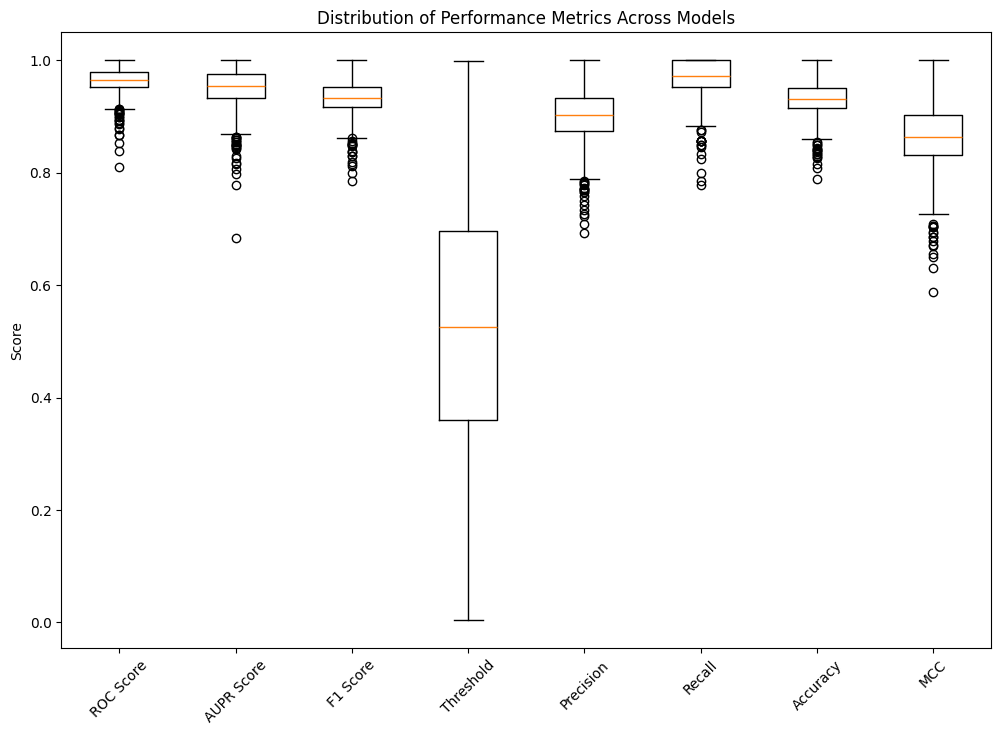

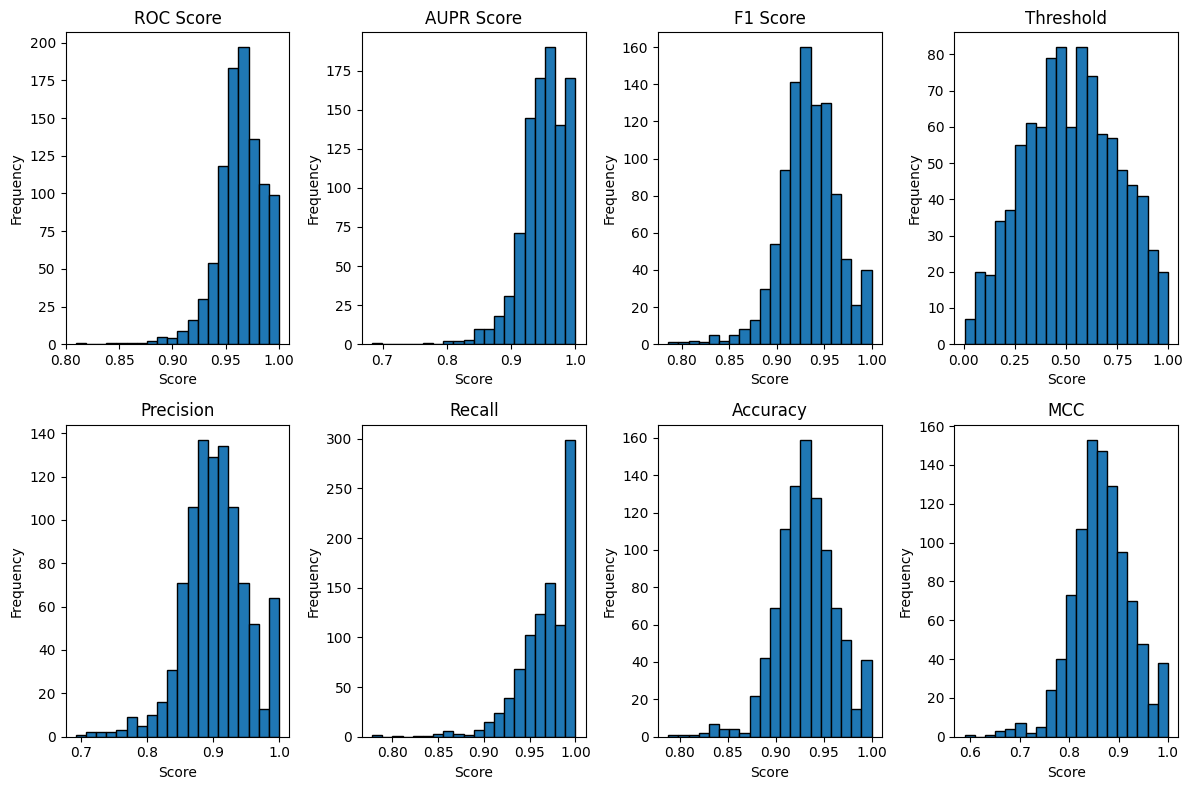

Correlation Matrix:
            ROC Score  AUPR Score  F1 Score  Threshold  Precision    Recall  \
ROC Score    1.000000    0.890222  0.805940   0.171918   0.731035  0.354771   
AUPR Score   0.890222    1.000000  0.732211   0.089098   0.689518  0.283497   
F1 Score     0.805940    0.732211  1.000000   0.190245   0.864543  0.516498   
Threshold    0.171918    0.089098  0.190245   1.000000   0.420067 -0.330012   
Precision    0.731035    0.689518  0.864543   0.420067   1.000000  0.020423   
Recall       0.354771    0.283497  0.516498  -0.330012   0.020423  1.000000   
Accuracy     0.836611    0.695487  0.968724   0.293992   0.877012  0.434983   
MCC          0.837113    0.691004  0.966453   0.276134   0.855497  0.473434   

            Accuracy       MCC  
ROC Score   0.836611  0.837113  
AUPR Score  0.695487  0.691004  
F1 Score    0.968724  0.966453  
Threshold   0.293992  0.276134  
Precision   0.877012  0.855497  
Recall      0.434983  0.473434  
Accuracy    1.000000  0.996196  
MCC 

In [43]:
import scipy.stats as stats

# Calculate and print average metrics
average_metrics = {
    "ROC Score": np.mean(roc_score),
    "AUPR Score": np.mean(aupr_score),
    "F1 Score": np.mean(f_score),
    "Threshold": np.mean(thr),
    "Precision": np.mean(precision),
    "Recall": np.mean(recall),
    "Accuracy": np.mean(acc),
    "MCC": np.mean(mcc)
}

std_metrics = {
    "ROC Score": np.std(roc_score),
    "AUPR Score": np.std(aupr_score),
    "F1 Score": np.std(f_score),
    "Threshold": np.std(thr),
    "Precision": np.std(precision),
    "Recall": np.std(recall),
    "Accuracy": np.std(acc),
    "MCC": np.std(mcc)
}

print("Average Metrics:")
for metric, value in average_metrics.items():
    print(f"{metric}: {value}")

print("\nStandard Deviation of Metrics:")
for metric, value in std_metrics.items():
    print(f"{metric}: {value}")

metrics_data = {
    "ROC Score": roc_score,
    "AUPR Score": aupr_score,
    "F1 Score": f_score,
    "Threshold": thr,
    "Precision": precision,
    "Recall": recall,
    "Accuracy": acc,
    "MCC": mcc
}

plt.figure(figsize=(12, 8))
plt.boxplot(metrics_data.values(), labels=metrics_data.keys())
plt.title("Distribution of Performance Metrics Across Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
for i, (metric, values) in enumerate(metrics_data.items(), 1):
    plt.subplot(2, 4, i)
    parts = plt.violinplot(values, showmeans=False, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor('blue')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    plt.title(metric)
    plt.ylabel("Score")

# Create histograms for each metric
plt.figure(figsize=(12, 8))
for i, (metric, values) in enumerate(metrics_data.items(), 1):
    plt.subplot(2, 4, i)
    plt.hist(values, bins=20, edgecolor='k')
    plt.title(metric)
    plt.xlabel("Score")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Create a DataFrame with all metrics
metrics_df = pd.DataFrame(metrics_data)

# Calculate the correlation matrix
correlation_matrix = metrics_df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

# Calculate confidence intervals for each metric
confidence_intervals = {}
for metric, values in metrics_data.items():
    mean = np.mean(values)
    sem = stats.sem(values)
    ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=sem)
    confidence_intervals[metric] = ci

print("Confidence Intervals:")
for metric, ci in confidence_intervals.items():
    print(f"{metric}: {ci}")

# 10/13
# Average Metrics:
# ROC Score: 0.9634593566411981
# AUPR Score: 0.9504965728510792
# F1 Score: 0.9336806482332225
# Threshold: 0.5268700122833252
# Precision: 0.9030678683342253
# Recall: 0.9683811972105018
# Accuracy: 0.9314636025403445
# MCC: 0.8657958272604677

# Standard Deviation of Metrics:
# ROC Score: 0.022200663109420326
# AUPR Score: 0.034691848124479126
# F1 Score: 0.03035570444435964
# Threshold: 0.22515156865119934
# Precision: 0.048192296430738406
# Recall: 0.031170948600577144
# Accuracy: 0.030789282051778256
# MCC: 0.05931060701567044

Learning Rate

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np

learning_rates = [0.001, 0.005, 0.01]
performance_metrics = []

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

def create_model(learning_rate):
    model = Sequential()
    model.add(Dense(input_dim=drug_feat.shape[1], kernel_initializer="glorot_normal", units=300))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))
    model.add(Dense(kernel_initializer="glorot_normal", units=200))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))
    model.add(Dense(kernel_initializer="glorot_normal", units=100))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))
    model.add(Dense(kernel_initializer="glorot_normal", units=1))  # output layer units=1
    model.add(Activation("sigmoid"))
    adam_optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
    return model

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = create_model(lr)
    
    roc_score, aupr_score, f_score, thr, precision, recall, acc, mcc = [], [], [], [], [], [], [], []
    
    for k in range(n_drugdrug_rel_types):
        print(f"Running for Relationship Type {k}")
        model.fit(train_org[k], train_label_org[k], batch_size=1024, epochs=50, 
                  validation_data=(val_org[k], val_label_org[k]), callbacks=[early_stopping])
        model.evaluate(test_org[k], test_label_org[k])
        y_probs = model.predict(test_org[k])

        roc = metrics.roc_auc_score(test_label_org[k], y_probs)
        aupr = metrics.average_precision_score(test_label_org[k], y_probs)
        fpr, tpr, thresholds = metrics.roc_curve(test_label_org[k], y_probs)
        scores = [metrics.f1_score(test_label_org[k], to_labels(y_probs, t)) for t in thresholds]
        ma = max(scores)
        idx = np.argmax(scores)
        bt = thresholds[idx]
        p = metrics.precision_score(test_label_org[k], to_labels(y_probs, bt))
        r = metrics.recall_score(test_label_org[k], to_labels(y_probs, bt))
        TP, FP, TN, FN = perf_measure(test_label_org[k], to_labels(y_probs, bt))
        ac = float(TP + TN) / (TP + FP + FN + TN)
        mc = metrics.matthews_corrcoef(test_label_org[k], to_labels(y_probs, bt))

        roc_score.append(roc)
        aupr_score.append(aupr)
        f_score.append(ma)
        thr.append(bt)
        precision.append(p)
        recall.append(r)
        acc.append(ac)
        mcc.append(mc)

    avg_roc = np.mean(roc_score)
    avg_aupr = np.mean(aupr_score)
    avg_f = np.mean(f_score)
    avg_thr = np.mean(thr)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_acc = np.mean(acc)
    avg_mcc = np.mean(mcc)

    metrics_dict = {
        "Learning Rate": lr,
        "Average ROC Score": avg_roc,
        "Average AUPR Score": avg_aupr,
        "Average F1 Score": avg_f,
        "Average Threshold": avg_thr,
        "Average Precision": avg_precision,
        "Average Recall": avg_recall,
        "Average Accuracy": avg_acc,
        "Average MCC": avg_mcc
    }
    performance_metrics.append(metrics_dict)

for metrics_dict in performance_metrics:
    print(f"Learning Rate: {metrics_dict['Learning Rate']}")
    print(f"Average ROC Score: {metrics_dict['Average ROC Score']}")
    print(f"Average AUPR Score: {metrics_dict['Average AUPR Score']}")
    print(f"Average F1 Score: {metrics_dict['Average F1 Score']}")
    print(f"Average Threshold: {metrics_dict['Average Threshold']}")
    print(f"Average Precision: {metrics_dict['Average Precision']}")
    print(f"Average Recall: {metrics_dict['Average Recall']}")
    print(f"Average Accuracy: {metrics_dict['Average Accuracy']}")
    print(f"Average MCC: {metrics_dict['Average MCC']}")
    print("\n")

Training with learning rate: 0.001
Running for Relationship Type 0
Epoch 1/50
25/25 [==============================] - 1s 17ms/step - loss: 0.6132 - accuracy: 0.6637 - val_loss: 0.4925 - val_accuracy: 0.7561
Epoch 2/50
25/25 [==============================] - 1s 25ms/step - loss: 0.4576 - accuracy: 0.7893 - val_loss: 0.4378 - val_accuracy: 0.7940
Epoch 3/50
25/25 [==============================] - 0s 11ms/step - loss: 0.4208 - accuracy: 0.8115 - val_loss: 0.4300 - val_accuracy: 0.8076
Epoch 4/50
25/25 [==============================] - 0s 11ms/step - loss: 0.3966 - accuracy: 0.8241 - val_loss: 0.4308 - val_accuracy: 0.7969
Epoch 5/50
25/25 [==============================] - 0s 11ms/step - loss: 0.3629 - accuracy: 0.8413 - val_loss: 0.4081 - val_accuracy: 0.8119
Epoch 6/50
25/25 [==============================] -

In [ ]:
for metrics_dict in performance_metrics:
    print(f"Learning Rate: {metrics_dict['Learning Rate']}")
    print(f"Average ROC Score: {metrics_dict['Average ROC Score']}")
    print(f"Average AUPR Score: {metrics_dict['Average AUPR Score']}")
    print(f"Average F1 Score: {metrics_dict['Average F1 Score']}")
    print(f"Average Threshold: {metrics_dict['Average Threshold']}")
    print(f"Average Precision: {metrics_dict['Average Precision']}")
    print(f"Average Recall: {metrics_dict['Average Recall']}")
    print(f"Average Accuracy: {metrics_dict['Average Accuracy']}")
    print(f"Average MCC: {metrics_dict['Average MCC']}")
    print("\n")

In [ ]:
df = pd.DataFrame(performance_metrics)
sorted_df = df.sort_values(by="F1 Score", ascending=False)

sorted_df

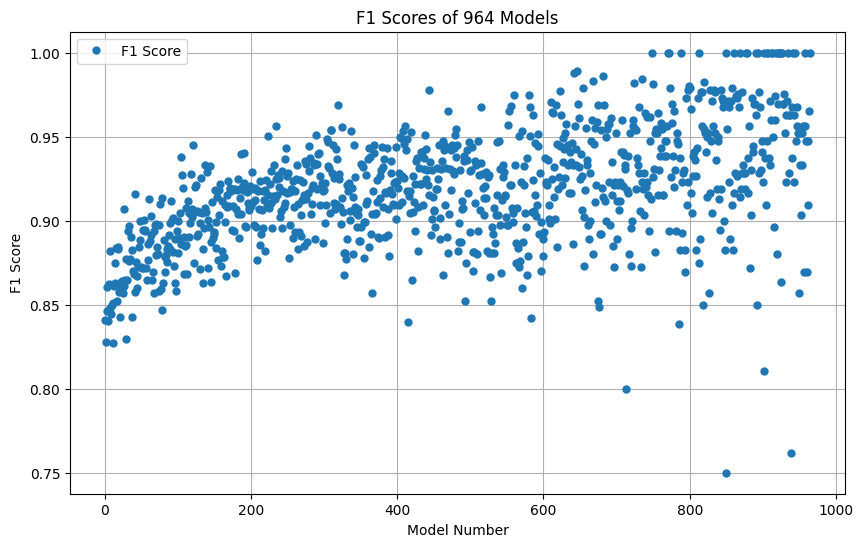

In [38]:
import matplotlib.pyplot as plt

# F1 scores for all 964 models
model_numbers = list(range(1, 965))

plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(model_numbers, f_score, marker='o', linestyle='', markersize=5, label='F1 Score')
plt.title('F1 Scores of 964 Models')
plt.xlabel('Model Number')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluate the feature Importance
* Step 1: Model Performance Evaluation
- ROC Score: Calculate the Receiver Operating Characteristic (ROC) score to measure the model's ability to distinguish between classes.
- AUPR Score: Calculate the Area Under the Precision-Recall Curve (AUPR) to evaluate the model's performance in the context of class imbalance.
- F1 Score: Compute the F1 Score as the harmonic mean of precision and recall, providing a balance between them.
- Accuracy: Calculate the accuracy to understand the overall effectiveness of the model.
- MCC: Compute the Matthews Correlation Coefficient (MCC) for a balanced measure of the model's quality.


* Step 2: Feature Importance Evaluation
- PCA Components: Analyze the principal components obtained from PCA to understand the variance explained by the drug label features.
- ChemBERTa Features: Evaluate the contribution of ChemBERTa embeddings to the model's predictions.
- Model Weights: Inspect the weights of the neural network layers to identify which features are given more importance.


##### IDEAS
Pros:

UMAP can capture both local and global data structures, potentially offering more meaningful representations for complex datasets.

Cons:

The interpretability of UMAP components is not as straightforward as PCA, where components have a clear variance explanation.


Interaction Features:

Drug-Drug Interactions: If your dataset includes information on drug-drug interactions, you can create features representing these interactions. This could involve creating interaction terms between drugs' features or encoding known interactions directly as features.
Side Effect Interactions: Similarly, if certain side effects are known to co-occur or influence each other, encoding these interactions as features could be beneficial.
Graph Features:

Drug Similarity Graphs: If you have similarity scores between drugs (e.g., based on chemical structure or side effect profiles), you can construct a similarity graph and use graph-based features such as node degree, clustering coefficients, or embeddings from graph neural networks.
Protein Interaction Networks: If your dataset includes information on drug targets and protein-protein interactions, incorporating features derived from these networks could provide valuable context for predicting side effects.
Advanced Embeddings:

Sequence-Based Embeddings: Beyond ChemBERTa, consider using or combining embeddings from other models trained on chemical sequences, such as Mol2vec or SMILES2Vec, to capture different aspects of chemical structure.
Property-Based Embeddings: Embeddings or features based on physical and chemical properties of drugs (e.g., molecular weight, solubility, logP) can provide complementary information to structural features.
Clustering-Based Features:

Cluster Labels as Features: Perform clustering on the drug features (e.g., using K-means) and use the cluster labels as categorical features. This can help the model leverage broader patterns in the data.
Distance to Cluster Centroids: Compute and use the distances from each drug to the centroids of the clusters as features, providing a measure of similarity to different drug "archetypes."
Feature Selection and Transformation:

Correlation Analysis: Analyze the correlation between features and the target variable(s), as well as among features themselves, to remove redundant or irrelevant features.
Non-linear Transformations: Apply non-linear transformations (e.g., polynomial features, interaction terms) to existing features to capture complex relationships in the data.
Temporal or Dosage Information (if available):

Time-Series Features: If you have temporal data on drug administration or side effect occurrence, you can create features capturing trends, periodicity, or changes over time.
Dosage Information: Features representing drug dosage, frequency of administration, or duration of treatment can be crucial for predicting side effects accurately.


In [ ]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import time
import pandas as pd
from azureml.core import Workspace, Datastore

workspace = Workspace.from_config()
default_datastore = workspace.get_default_datastore()
csv_file_path = "transformer_chemBERTa_smiles_nnps_performance_metrics.csv"
sorted_df.to_csv(csv_file_path, index=False)

# Upload the CSV file to the root of the Datastore
default_datastore.upload_files([csv_file_path], target_path=".", overwrite=True, show_progress=True)

# Create a new version of the data asset
v2 = "cleaned" + time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())
my_path = f"./{csv_file_path}"

# Define the data asset, and use tags to make it clear the asset can be used in training
my_data = Data(
    name="transformer_chemBERTa_smiles-performance-metrics",
    version=v2,
    description="Performance metrics for transformer_chemBERTa_smiles on NNPS data.",
    tags={"training_data": "true", "format": "csv"},
    path=my_path,
    type=AssetTypes.URI_FILE,
)

# Create or update the data asset
my_data = ml_client.data.create_or_update(my_data)

print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

## **Grid Search**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np

# Define the model creation function
def create_model(learning_rate=0.01, dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(300, input_dim=drug_feat.shape[1], kernel_initializer="glorot_normal"))
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(200, kernel_initializer="glorot_normal"))
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(100, kernel_initializer="glorot_normal"))
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer="glorot_normal"))
    model.add(Activation("sigmoid"))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'learning_rate': [0.01],
    'dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [512, 1024, 2048],
    'epochs': [50]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the model
grid_result = grid.fit(train_org, train_label_org)

# Print the best parameters and best score
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Extract the best model
best_model = grid_result.best_estimator_.model

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Initialize lists to store performance metrics
roc_score = []
aupr_score = []
f_score = []
thr = []
precision = []
recall = []
tpos = []
fpos = []
tneg = []
fneg = []
acc = []
mcc = []
performance_metrics = []

# Loop over drug-drug relationship side effect (964)
for k in range(n_drugdrug_rel_types):
    print(f"Running for Relationship Type {k}")
    
    # Train the model with early stopping
    best_model.fit(train_org[k], train_label_org[k], batch_size=grid_result.best_params_['batch_size'], epochs=grid_result.best_params_['epochs'], 
                   validation_data=(val_org[k], val_label_org[k]), callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    best_model.evaluate(test_org[k], test_label_org[k])
    
    # Predict probabilities on the test set
    y_probs = best_model.predict(test_org[k])
    
    roc = metrics.roc_auc_score(test_label_org[k], y_probs)
    aupr = metrics.average_precision_score(test_label_org[k], y_probs)
    fpr, tpr, thresholds = metrics.roc_curve(test_label_org[k], y_probs)
    scores = [metrics.f1_score(test_label_org[k], to_labels(y_probs, t)) for t in thresholds]
    ma = max(scores)
    idx = np.argmax(scores)
    bt = thresholds[idx]
    p = metrics.precision_score(test_label_org[k], to_labels(y_probs, bt))
    r = metrics.recall_score(test_label_org[k], to_labels(y_probs, bt))
    
    TP, FP, TN, FN = perf_measure(test_label_org[k], to_labels(y_probs, bt))
    ac = float(TP + TN) / (TP + FP + FN + TN)
    mc = metrics.matthews_corrcoef(test_label_org[k], to_labels(y_probs, bt))

    roc_score.append(roc)
    aupr_score.append(aupr)
    f_score.append(ma)
    thr.append(bt)
    precision.append(p)
    recall.append(r)
    tpos.append(TP)
    fpos.append(FP)
    tneg.append(TN)
    fneg.append(FN)
    acc.append(ac)
    mcc.append(mc)
    
    metrics_dict = {
        "Relationship Type": k,
        "ROC Score": roc,
        "AUPR Score": aupr,
        "F1 Score": ma,
        "Threshold": bt,
        "Precision": p,
        "Recall": r,
        "True Positives": TP,
        "False Positives": FP,
        "True Negatives": TN,
        "False Negatives": FN,
        "Accuracy": ac,
        "MCC": mc
    }
    performance_metrics.append(metrics_dict)

print(f"Average ROC Score: {np.mean(roc_score)}")
print(f"Average AUPR Score: {np.mean(aupr_score)}")
print(f"Average F1 Score: {np.mean(f_score)}")
print(f"Average Threshold: {np.mean(thr)}")
print(f"Average Precision: {np.mean(precision)}")
print(f"Average Recall: {np.mean(recall)}")
print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average MCC: {np.mean(mcc)}")

In [ ]:
# ! pip uninstall tensorflow
! pip install tensorflow==2.12.0

## **Random Forest for Feature Selection **

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Assuming `drug_feat` is your feature matrix and `labels` is your target variable
model = RandomForestClassifier()
model.fit(drug_feat, labels)

# Get feature importances
importances = model.feature_importances_

# Optionally, plot the feature importances for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(drug_feat.shape[1]), importances)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, matthews_corrcoef
import numpy as np

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    roc = roc_auc_score(y_test, predictions)
    aupr = average_precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    mcc = matthews_corrcoef(y_test, predictions)
    return roc, aupr, f1, precision, recall, mcc

def select_features(model, threshold=0.01):
    importances = model.feature_importances_
    return np.where(importances > threshold)[0]

performance_metrics_all_features = []
performance_metrics_selected_features = []

for k in range(n_drugdrug_rel_types):
    print(f"Running for Relationship Type {k}")
    
    model = RandomForestClassifier(n_estimators=100)
    model.fit(train_org[k], train_label_org[k])
    
    roc, aupr, f1, precision, recall, mcc = evaluate_model(model, test_org[k], test_label_org[k])
    
    performance_metrics_all_features.append({
        "Relationship Type": k,
        "ROC Score": roc,
        "AUPR Score": aupr,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "MCC": mcc
    })
 
    important_features_indices = select_features(model, threshold=0.01)  # Example threshold
    train_selected = train_org[k][:, important_features_indices]
    test_selected = test_org[k][:, important_features_indices]
    
    model_selected = RandomForestClassifier(n_estimators=100)
    model_selected.fit(train_selected, train_label_org[k])
    
    roc, aupr, f1, precision, recall, mcc = evaluate_model(model_selected, test_selected, test_label_org[k])

    performance_metrics_selected_features.append({
        "Relationship Type": k,
        "ROC Score": roc,
        "AUPR Score": aupr,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "MCC": mcc
    })


# Note: The above code is a simplified example. You need to define or adjust the `evaluate_model` and `select_important_features` functions based on your actual data and requirements.

In [ ]:
# #-----------------------------------------------------------------------
#construct model
# model = Sequential()
# model.add(Dense(input_dim=drug_feat.shape[1], kernel_initializer="glorot_normal",units=300))
# model.add(Activation("relu"))
# model.add(Dropout(0.1))
# model.add(Dense(input_dim=300, kernel_initializer="glorot_normal", units=200))
# model.add(Activation("relu"))
# model.add(Dropout(0.1))
# model.add(Dense(input_dim=200, kernel_initializer="glorot_normal", units=100))
# model.add(Activation("relu"))
# model.add(Dropout(0.1))
# model.add(Dense(input_dim=100, kernel_initializer="glorot_normal", units=1))
# model.add(Activation("sigmoid"))
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
#------------------------------------------------------------------------
#get criteria
# roc_score=[]
# aupr_score=[]
# f_score=[]
# thr=[]
# precision=[]
# recall=[]
# tpos=[]
# fpos=[]
# tneg=[]
# fneg=[]
# acc=[]
# mcc=[]
# for k in range(n_drugdrug_rel_types):
#     print(k)
#     model.fit(train_org[k],train_label_org[k],batch_size=1024, epochs=50)
#     model.evaluate(val_org[k], val_label_org[k])
#     model.evaluate(test_org[k], test_label_org[k])
#     roc=metrics.roc_auc_score(test_label_org[k],model.predict(test_org[k]))
#     roc_score.append(roc)
#     aupr=metrics.average_precision_score(test_label_org[k],model.predict(test_org[k]))
#     aupr_score.append(aupr)
#     fpr, tpr, thresholds=metrics.roc_curve(test_label_org[k],model.predict(test_org[k]))
#     scores=[metrics.f1_score(test_label_org[k], to_labels(model.predict(test_org[k]), t)) for t in thresholds]
#     ma= max(scores)
#     f_score.append(ma)
#     idx=np.argmax(scores)
#     bt=thresholds[idx]
#     thr.append(bt)
#     p=metrics.precision_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
#     precision.append(p)
#     r=metrics.recall_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
#     recall.append(r)
#     TP, FP, TN, FN=perf_measure(test_label_org[k],to_labels(model.predict(test_org[k]), bt))
#     tpos.append(TP)
#     fpos.append(FP)
#     tneg.append(TN)
#     fneg.append(FN)
#     ac = float(TP + TN)/(TP+FP+FN+TN)
#     acc.append(ac)
#     mc=metrics.matthews_corrcoef(test_label_org[k],to_labels(model.predict(test_org[k]), bt))
#     mcc.append(mc)
# model.save("model.h5")

# loaded_model =load_model("model.h5")
# loaded_model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
# for k in range(541):
#     print(k)
#     model.fit(train_org[k],train_label_org[k],batch_size=1024, epochs=50)
#     model.evaluate(val_org[k], val_label_org[k])
#     model.evaluate(test_org[k], test_label_org[k])
#     roc=metrics.roc_auc_score(test_label_org[k],model.predict(test_org[k]))
#     roc_score[k]=roc
#     aupr=metrics.average_precision_score(test_label_org[k],model.predict(test_org[k]))
#     aupr_score[k]=aupr
#     fpr, tpr, thresholds=metrics.roc_curve(test_label_org[k],model.predict(test_org[k]))
#     scores=[metrics.f1_score(test_label_org[k], to_labels(model.predict(test_org[k]), t)) for t in thresholds]
#     ma= max(scores)
#     f_score[k]=ma
#     idx=np.argmax(scores)
#     bt=thresholds[idx]
#     thr[k]=bt
#     p=metrics.precision_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
#     precision[k]=p
#     r=metrics.recall_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
#     recall[k]=r
#     TP, FP, TN, FN=perf_measure(test_label_org[k],to_labels(model.predict(test_org[k]), bt))
#     tpos[k]=TP
#     fpos[k]=FP
#     tneg[k]=TN
#     fneg[k]=FN
#     ac = float(TP + TN)/(TP+FP+FN+TN)
#     acc[k]=ac
#     mc=metrics.matthews_corrcoef(test_label_org[k],to_labels(model.predict(test_org[k]), bt))
#     mcc[k]=mc

In [ ]:
roc_score = []
aupr_score = []
f_score = []
thr = []
precision = []
recall = []
tpos = []
fpos = []
tneg = []
fneg = []
acc = []
mcc = []
performance_metrics = []

# Loop over drug-drug relationship side effect (964)
for k in range(n_drugdrug_rel_types):
    
    print(f"Running for Relationship Type {k}")
    print(f"Total Number of Relationship Types: {n_drugdrug_rel_types}")
    
    model.fit(train_org[k], train_label_org[k], batch_size=1024, epochs=50) #TODO: epochs=50 in original code
    model.evaluate(val_org[k], val_label_org[k])
    
    model.evaluate(test_org[k], test_label_org[k])
    roc = metrics.roc_auc_score(test_label_org[k], model.predict(test_org[k]))
    aupr = metrics.average_precision_score(test_label_org[k], model.predict(test_org[k]))
    fpr, tpr, thresholds = metrics.roc_curve(test_label_org[k], model.predict(test_org[k]))
    scores = [metrics.f1_score(test_label_org[k], to_labels(model.predict(test_org[k]), t)) for t in thresholds]
    ma = max(scores)
    idx = np.argmax(scores)
    bt = thresholds[idx]
    p = metrics.precision_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
    r = metrics.recall_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
    
    TP, FP, TN, FN = perf_measure(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
    ac = float(TP + TN) / (TP + FP + FN + TN)
    mc = metrics.matthews_corrcoef(test_label_org[k], to_labels(model.predict(test_org[k]), bt))

    roc_score.append(roc)
    aupr_score.append(aupr)
    f_score.append(ma)
    thr.append(bt)
    precision.append(p)
    recall.append(r)
    tpos.append(TP)
    fpos.append(FP)
    tneg.append(TN)
    fneg.append(FN)
    acc.append(ac)
    mcc.append(mc)
    metrics_dict = {
        "Relationship Type": k,
        "ROC Score": roc,
        "AUPR Score": aupr,
        "F1 Score": ma,
        "Threshold": bt,
        "Precision": p,
        "Recall": r,
        "True Positives": TP,
        "False Positives": FP,
        "True Negatives": TN,
        "False Negatives": FN,
        "Accuracy": ac,
        "MCC": mc
    }
    performance_metrics.append(metrics_dict)
 
    # model.save(f"nnps_{k}.h5")
    # loaded_model = load_model("nnps_964.h5")

### **Word2vec**

In [ ]:
# Process train drugs for each side effect k seperately
for k in range(n_drugdrug_rel_types):
    unique_train_drug_ids = set()
    for pair in train[k]:  # train[k] is specific to side effect type k
        for idx in pair:
            drug_id = lst[idx]
            unique_train_drug_ids.add(drug_id)
    
    # Extract and tokenize SMILES strings as before
    train_smiles = [drug_id_to_smiles[drug_id] for drug_id in unique_train_drug_ids if drug_id in drug_id_to_smiles]
    train_corpus = [list(smiles) for smiles in train_smiles]
    
    # Train the Word2Vec model for side effect type k
    model = Word2Vec(sentences=train_corpus, vector_size=100, window=5, min_count=1, workers=4)
    model.save(f"word2vec_model_side_effect_{k}.model")

In [ ]:
word2vec_models = {}

for k in range(n_drugdrug_rel_types):
    train_drugs = set([drug for pairs in train for pair in pairs for drug in pair])
    train_smiles = [tokenized_smiles[drug] for drug in train_drugs if drug in tokenized_smiles]
    if train_smiles:
        model = Word2Vec(sentences=train_smiles, vector_size=100, window=5, min_count=1, workers=4)
        word2vec_models[k] = model
    # Train the Word2Vec model
    model = Word2Vec(sentences=train_smiles, vector_size=100, window=5, min_count=1, workers=4)
        

In [ ]:
#------------------------------------------------------------------------
#construct drug features
se_mono=[]
for k in se2name_mono:
    se_mono.append(k)
drug_label=np.zeros((n_drugs,len(se_mono)))
for key,value in stitch2se.items():
    j=lst.index(key)
    for v in value:
        i=se_mono.index(v)
        drug_label[j,i]=1
pca = PCA(.95)
pca.fit(drug_label)
pca_= PCA(.95)
pca_.fit(drug_protein_adj)
drug_feat = np.concatenate((pca.transform(drug_label),pca_.transform(drug_protein_adj)),axis=1)
#------------------------------------------------------------------------
#construct train & validation & test sets
val_sets=[]
val_labels=[]
for k in range(n_drugdrug_rel_types):
    v=[]
    a=[]
    for  i in val[k]:
        v.append(drug_feat[i[0]]+drug_feat[i[1]])
        a.append(drug_drug_adj_list[k][i[0],i[1]])
    val_sets.append(v)
    val_labels.append(a)
test_sets=[]
test_labels=[]
for k in range(n_drugdrug_rel_types):
    te=[]
    a=[]
    for  i in test[k]:
        te.append(drug_feat[i[0]]+drug_feat[i[1]])
        a.append(drug_drug_adj_list[k][i[0],i[1]])
    test_sets.append(te)
    test_labels.append(a)
train_sets=[]
train_labels=[]
for k in range(n_drugdrug_rel_types):
    tr=[]
    a=[]
    for  i in train[k]:
        tr.append(drug_feat[i[0]]+drug_feat[i[1]])
        a.append(drug_drug_adj_list[k][i[0],i[1]])
    train_sets.append(tr)
    train_labels.append(a)
val_org=[]
val_label_org=[]
test_org=[]
test_label_org=[]
train_org=[]
train_label_org=[]
for k in range(n_drugdrug_rel_types):
    val_org.append(np.array(val_sets[k]))
    val_label_org.append(np.array(val_labels[k]))
    test_org.append(np.array(test_sets[k]))
    test_label_org.append(np.array(test_labels[k]))
    train_org.append(np.array(train_sets[k]))
    train_label_org.append(np.array(train_labels[k]))

In [ ]:
for pair in train[0]:  # Assuming side effect 0
    print(f"Drug pair: {lst[pair[0]]} and {lst[pair[1]]}")

In [ ]:
# #-----------------------------------------------------------------------
#construct model
model = Sequential()
model.add(Dense(input_dim=drug_feat.shape[1], kernel_initializer="glorot_normal",units=300))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=300, kernel_initializer="glorot_normal", units=200))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=200, kernel_initializer="glorot_normal", units=100))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=100, kernel_initializer="glorot_normal", units=1))
model.add(Activation("sigmoid"))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
#------------------------------------------------------------------------
#get criteria
roc_score=[]
aupr_score=[]
f_score=[]
thr=[]
precision=[]
recall=[]
tpos=[]
fpos=[]
tneg=[]
fneg=[]
acc=[]
mcc=[]
for k in range(n_drugdrug_rel_types):
    print(k)
    model.fit(train_org[k],train_label_org[k],batch_size=1024, epochs=50)
    model.evaluate(val_org[k], val_label_org[k])
    model.evaluate(test_org[k], test_label_org[k])
    roc=metrics.roc_auc_score(test_label_org[k],model.predict(test_org[k]))
    roc_score.append(roc)
    aupr=metrics.average_precision_score(test_label_org[k],model.predict(test_org[k]))
    aupr_score.append(aupr)
    fpr, tpr, thresholds=metrics.roc_curve(test_label_org[k],model.predict(test_org[k]))
    scores=[metrics.f1_score(test_label_org[k], to_labels(model.predict(test_org[k]), t)) for t in thresholds]
    ma= max(scores)
    f_score.append(ma)
    idx=np.argmax(scores)
    bt=thresholds[idx]
    thr.append(bt)
    p=metrics.precision_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
    precision.append(p)
    r=metrics.recall_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
    recall.append(r)
    TP, FP, TN, FN=perf_measure(test_label_org[k],to_labels(model.predict(test_org[k]), bt))
    tpos.append(TP)
    fpos.append(FP)
    tneg.append(TN)
    fneg.append(FN)
    ac = float(TP + TN)/(TP+FP+FN+TN)
    acc.append(ac)
    mc=metrics.matthews_corrcoef(test_label_org[k],to_labels(model.predict(test_org[k]), bt))
    mcc.append(mc)
model.save("model.h5")
# loaded_model =load_model("model.h5")
# loaded_model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
# for k in range(541):
#     print(k)
#     model.fit(train_org[k],train_label_org[k],batch_size=1024, epochs=50)
#     model.evaluate(val_org[k], val_label_org[k])
#     model.evaluate(test_org[k], test_label_org[k])
#     roc=metrics.roc_auc_score(test_label_org[k],model.predict(test_org[k]))
#     roc_score[k]=roc
#     aupr=metrics.average_precision_score(test_label_org[k],model.predict(test_org[k]))
#     aupr_score[k]=aupr
#     fpr, tpr, thresholds=metrics.roc_curve(test_label_org[k],model.predict(test_org[k]))
#     scores=[metrics.f1_score(test_label_org[k], to_labels(model.predict(test_org[k]), t)) for t in thresholds]
#     ma= max(scores)
#     f_score[k]=ma
#     idx=np.argmax(scores)
#     bt=thresholds[idx]
#     thr[k]=bt
#     p=metrics.precision_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
#     precision[k]=p
#     r=metrics.recall_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
#     recall[k]=r
#     TP, FP, TN, FN=perf_measure(test_label_org[k],to_labels(model.predict(test_org[k]), bt))
#     tpos[k]=TP
#     fpos[k]=FP
#     tneg[k]=TN
#     fneg[k]=FN
#     ac = float(TP + TN)/(TP+FP+FN+TN)
#     acc[k]=ac
#     mc=metrics.matthews_corrcoef(test_label_org[k],to_labels(model.predict(test_org[k]), bt))
#     mcc[k]=mc

In [ ]:
#---------------------------------------------------------------------------
val_test_size=0.05
n_drugs=645
n_proteins=8934
n_drugdrug_rel_types=964

#---------------------------------------------------------------------------
#list of drugs
lst=[]
for key , value in combo2stitch.items():
  first_name, second_name = map(lambda x: x.strip(), key.split("_"))
  if first_name not in lst:
    lst.append(first_name)
  if second_name not in lst:
    lst.append(second_name)
#---------------------------------------------------------------------------
#list of proteins
p=[]
for k,v in stitch2proteins_all.items():
    for i in v:
        if i not in p:
            p.append(i)
#---------------------------------------------------------------------------
#construct drug-protein-adj matrix
drug_protein_adj=np.zeros((n_drugs,n_proteins))
for i in range(n_drugs):
    for j in stitch2proteins_all[lst[i]]:
        k=p.index(j)
        drug_protein_adj[i,k]=1
#---------------------------------------------------------------------------
#construct drug-drug-adj matrices for all side effects
drug_drug_adj_list=[]
l=[]
for i in range(n_drugdrug_rel_types):
  print(i)
  mat = np.zeros((n_drugs, n_drugs))
  l.append(df.at[i,"Side Effect"])
  for se in l:
    print(se)
    for d1, d2 in combinations(list(range(n_drugs)), 2):
      if lst[d1]+"_"+lst[d2]  in combo2se:
        if se in combo2se[lst[d1]+"_"+lst[d2]]:
            mat[d1,d2]=mat[d2,d1]=1
  l=[]
  drug_drug_adj_list.append(mat)
drug_degrees_list = [np.array(drug_adj.sum(axis=0)).squeeze() for drug_adj in drug_drug_adj_list]
#-------------------------------------------------------------------------

In [ ]:
drug_drug_adj_list[0].shape # adjacency matrix for side effect "arterial pressure NOS decreased" C0020649 id is 0 with dims (645, 645)

In [ ]:
lst[0]

In [ ]:
len(lst)

In [ ]:
#-------------------------------------------------------------------------
#select drug pairs for training & validation & testing
edges=[]
for k in range(n_drugdrug_rel_types):
    l=[]
    for i in range(n_drugs):
        for j in range(n_drugs):
            if drug_drug_adj_list[k][i,j]==1:
                l.append([i,j])
    edges.append(l)
edges_false=[]
for k in range(n_drugdrug_rel_types):
    l=[]
    for i in range(n_drugs):
        for j in range(n_drugs):
            if drug_drug_adj_list[k][i,j]==0:
                l.append([i,j])
    edges_false.append(l)

# Random Shuffling of Drug Pairs: For each relationship type (k), 
# the drug pairs (val[k], test[k], train[k]) are randomly shuffled. 
# Ensure a random distribution of drug pairs across the sets.
for k in range(n_drugdrug_rel_types):
    np.random.shuffle(edges[k])
    np.random.shuffle(edges_false[k])
for k in range(n_drugdrug_rel_types):
    a=len(edges[k])
    edges_false[k]=edges_false[k][:a]
edges_all=[]
for k in range(n_drugdrug_rel_types):
    edges_all.append(edges[k]+edges_false[k])
for k in range(n_drugdrug_rel_types):
    np.random.shuffle(edges_all[k])
for k in range(n_drugdrug_rel_types):
    a=len(edges[k])
    edges_all[k]=edges_all[k][:a]
val=[]
test=[]
train=[]
# After shuffling, portion of drug pairs is selected for validation (val[k]), testing (test[k]), and training (train[k])
for k in range(n_drugdrug_rel_types):
    a=int(np.floor(len(edges_all[k])*val_test_size)) # val 5%, test 5%
    val.append(edges_all[k][:a])
    test.append(edges_all[k][a:a+a])
    train.append(edges_all[k][a+a:])

# val - contains drug pairs for validation 
# [[[215, 6],
#   [201, 307],
#   [642, 236],



## **SMILES**

In [ ]:
drug_info_dict = {}

for drug_id in lst:
    matching_rows = polypharmacycorpus[polypharmacycorpus["STITCH 1"] == drug_id]
    
    if not matching_rows.empty:
        stitch_name_x = matching_rows.iloc[0]["STITCH NAME_x"]
        drug_info_dict[drug_id] = stitch_name_x
    else:
        matching_rows = polypharmacycorpus[polypharmacycorpus["STITCH 2"] == drug_id]
        if not matching_rows.empty:
            stitch_name_y = matching_rows.iloc[0]["STITCH NAME_y"]
            drug_info_dict[drug_id] = stitch_name_y
        else:
            # Handle the case where no matching row is found for the drug_id in both columns
            drug_info_dict[drug_id] = "Name not found"

len(drug_info_dict)
# check
# not_found_drugs = {drug_id: name for drug_id, name in drug_info_dict.items() if name == "Name not found"}
# print(len(not_found_drugs))
# print(not_found_drugs)


In [ ]:
drug_info_dict

In [ ]:
import requests

def get_smiles(drug_id):
    try:
        # Use the PubChem API to search for the compound by name and retrieve its Canonical SMILES
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{(drug_id)}/property/CanonicalSMILES/JSON"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            smiles = data["PropertyTable"]["Properties"][0]["CanonicalSMILES"]
            return smiles
        else:
            return "No SMILES found"
    except Exception as e:
        return f"Error: {str(e)}"

drug_smiles_dict = drug_info_dict.copy()

for key, value in drug_smiles_dict.items():
    drug_smiles_dict[key] = get_smiles(value)



In [ ]:
drug_smiles_dict

In [ ]:
#-------------------------------------------------------------------------
#select drug pairs for training & validation & testing
edges=[]
for k in range(n_drugdrug_rel_types):
    l=[]
    for i in range(n_drugs):
        for j in range(n_drugs):
            if drug_drug_adj_list[k][i,j]==1:
                l.append([i,j])
    edges.append(l)
edges_false=[]
for k in range(n_drugdrug_rel_types):
    l=[]
    for i in range(n_drugs):
        for j in range(n_drugs):
            if drug_drug_adj_list[k][i,j]==0:
                l.append([i,j])
    edges_false.append(l)
for k in range(n_drugdrug_rel_types):
    np.random.shuffle(edges[k])
    np.random.shuffle(edges_false[k])
for k in range(n_drugdrug_rel_types):
    a=len(edges[k])
    edges_false[k]=edges_false[k][:a]
edges_all=[]
for k in range(n_drugdrug_rel_types):
    edges_all.append(edges[k]+edges_false[k])
for k in range(n_drugdrug_rel_types):
    np.random.shuffle(edges_all[k])
for k in range(n_drugdrug_rel_types):
    a=len(edges[k])
    edges_all[k]=edges_all[k][:a]
val=[]
test=[]
train=[]
for k in range(n_drugdrug_rel_types):
    a=int(np.floor(len(edges_all[k])*val_test_size))
    val.append(edges_all[k][:a])
    test.append(edges_all[k][a:a+a])
    train.append(edges_all[k][a+a:])

**Features + SMILES**

In [ ]:
import numpy as np
from gensim.models import Word2Vec

def lookup_smiles_dict(drg_id):
    if drug_id in drug_smiles_dict:
        return drug_smiles_dict[drug_id]
    else:
        return "Does not exist in dict, drug_smiles_dict"
    

def tokenize_smiles_on_equal(smiles):
    """
    Tokenize a SMILES string by splitting on the "=" character.
    
    Args:
        smiles (str): The SMILES string to tokenize.
        
    Returns:
        list of str: The list of tokens obtained by splitting on "=".
    """
    tokens = smiles.split("=")
    final_tokens = []
    for i, token in enumerate(tokens):
        if i == 0:
            final_tokens.append(token)
        else:
            final_tokens.append("=" + token)
        if i < len(tokens) - 1 and final_tokens:
            final_tokens[-1] = final_tokens[-1] + "="
    return final_tokens

word2vec_models = {}

# Train a Word2Vec model for each side effect type
for k in range(1): # n_drugdrug_rel_types): TODO 
    train_drug_positions = [pair for sublist in train[k] for pair in sublist]
    # print(f"train_drug_positions for side effect type {k}:", train_drug_positions)

    train_drug_ids = [lst[pos] for pos in train_drug_positions]
    # print(f"train_drug_ids for side effect type {k}:", train_drug_ids)
    print("Side effect 0, len train_drug_ids", (len(train_drug_ids))) # for side eff 0, we have 50336 drugs in train
    unique_drug_ids = set([lst[pos] for sublist in train[0] for pos in sublist])
    print(f"Unique drug IDs count: {len(unique_drug_ids)}")

    smiles_data = {drug_id: lookup_smiles_dict(drug_id) for drug_id in train_drug_ids}
    print(smiles_data)
    print("/n")
    tokenized_smiles = [tokenize_smiles_on_equal(smiles) for smiles in smiles_data.values()]
    print(tokenized_smiles)
    
    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_smiles, vector_size=100, window=5, min_count=1, workers=4)
    model.train(tokenized_smiles, total_examples=len(tokenized_smiles), epochs=10)
    
    # Store the trained model
    word2vec_models[k] = model

def vectorize_smiles(smiles, word2vec_model):
    """
    Vectorize a SMILES string using a trained Word2Vec model.
    
    Args:
        smiles (str): The SMILES string to vectorize.
        word2vec_model (Word2Vec): The trained Word2Vec model.
        
    Returns:
        np.array: The vector representation of the SMILES string.
    """
    vectors = [word2vec_model.wv[token] for token in tokenize_smiles_on_equal(smiles) if token in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

side_effect_type = 0
model_for_side_effect = word2vec_models[side_effect_type]
# smiles_example = "CC1=CN(C(=O)NC1=O)C2C=CC(O2)CO"
# vector_example = vectorize_smiles(smiles_example, model_for_side_effect)
# print(vector_example)


In [ ]:
# Assuming `word2vec_models` contains your trained Word2Vec model
model_for_side_effect = word2vec_models[0]  # Example for side effect type 0

# Fentanyl SMILES string
fentanyl_smiles = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"

# Tokenize the fentanyl SMILES string
tokenized_fentanyl = tokenize_smiles_on_equal(fentanyl_smiles)

# Assuming you have a dictionary `drug_smiles_dict` with drug IDs as keys and SMILES strings as values
# Tokenize all SMILES strings in the dataset
tokenized_smiles_dataset = {drug_id: tokenize_smiles_on_equal(smiles) for drug_id, smiles in drug_smiles_dict.items()}

# Vectorize the fentanyl SMILES string
fentanyl_vector = vectorize_smiles(fentanyl_smiles, model_for_side_effect)

# Find the most similar SMILES string
# This step is a bit tricky because `most_similar` expects a key from the model"s vocabulary, not a vector.
# One approach is to find the most similar tokens for each token in the fentanyl SMILES string,
# then aggregate these to find the most similar SMILES strings in your dataset.

# For a more direct approach to finding the most similar SMILES string based on vector similarity,
# you would need to implement a custom similarity measure, such as cosine similarity,
# between the fentanyl vector and all vectors in your dataset, then pick the highest.

# Example of calculating cosine similarity (not directly applicable here but gives an idea)
from scipy.spatial.distance import cosine

# Calculate cosine similarity between fentanyl vector and all vectors in your dataset
similarities = {}
for drug_id, smiles in drug_smiles_dict.items():
    vector = vectorize_smiles(smiles, model_for_side_effect)
    similarity = 1 - cosine(fentanyl_vector, vector)  # Cosine similarity
    similarities[drug_id] = similarity

# Find the drug ID with the highest similarity
most_similar_drug_id = max(similarities, key=similarities.get)

# Get the SMILES string for the most similar drug
most_similar_smiles = drug_smiles_dict[most_similar_drug_id]

print(f"Most similar to fentanyl: {most_similar_smiles}")

In [ ]:
# model_for_side_effect = word2vec_models[0] 
# fentanyl_smiles = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"
# tokenized_fentanyl = tokenize_smiles_on_equal(fentanyl_smiles)

# # Assuming you have a trained model for a specific side effect type
# model_for_side_effect = word2vec_models[0]  # Example for side effect type 0

# # Find and print the most similar tokens for each token in the fentanyl SMILES string
# for token in tokenized_fentanyl:
#     if token in model_for_side_effect.wv:  # Check if the token is in the model"s vocabulary
#         similar_tokens = model_for_side_effect.wv.most_similar(token)
#         print(f"Most similar to "{token}": {similar_tokens}")
#     else:
#         print(f"Token "{token}" not in vocabulary.")

In [ ]:
# # Assuming `get_smiles` function is defined elsewhere to fetch SMILES strings for drug IDs

# # Update feature vector creation for validation, test, and training sets
# val_sets, val_labels = [], []
# test_sets, test_labels = [], []
# train_sets, train_labels = [], []

# for k in range(n_drugdrug_rel_types):
#     model = word2vec_models[k]  # Get the Word2Vec model for the current side effect type
#     v_val, a_val = [], []
#     v_test, a_test = [], []
#     v_train, a_train = [], []
    
#     # Validation set
#     for i in val[k]:
#         smiles1, smiles2 = get_smiles(i[0]), get_smiles(i[1])
#         vector1, vector2 = vectorize_smiles(smiles1, model), vectorize_smiles(smiles2, model)
#         v_val.append(np.concatenate((vector1, vector2)))
#         a_val.append(drug_drug_adj_list[k][i[0],i[1]])
#     val_sets.append(v_val)
#     val_labels.append(a_val)
    
#     # Test set
#     for i in test[k]:
#         smiles1, smiles2 = get_smiles(i[0]), get_smiles(i[1])
#         vector1, vector2 = vectorize_smiles(smiles1, model), vectorize_smiles(smiles2, model)
#         v_test.append(np.concatenate((vector1, vector2)))
#         a_test.append(drug_drug_adj_list[k][i[0],i[1]])
#     test_sets.append(v_test)
#     test_labels.append(a_test)
    
#     # Training set
#     for i in train[k]:
#         smiles1, smiles2 = get_smiles(i[0]), get_smiles(i[1])
#         vector1, vector2 = vectorize_smiles(smiles1, model), vectorize_smiles(smiles2, model)
#         v_train.append(np.concatenate((vector1, vector2)))
#         a_train.append(drug_drug_adj_list[k][i[0],i[1]])
#     train_sets.append(v_train)
#     train_labels.append(a_train)

# # Convert lists to NumPy arrays
# val_org, val_label_org, test_org, test_label_org, train_org, train_label_org = [], [], [], [], [], []
# for k in range(n_drugdrug_rel_types):
#     val_org.append(np.array(val_sets[k]))
#     val_label_org.append(np.array(val_labels[k]))
#     test_org.append(np.array(test_sets[k]))
#     test_label_org.append(np.array(test_labels[k]))
#     train_org.append(np.array(train_sets[k]))
#     train_label_org.append(np.array(train_labels[k]))

In [ ]:
# # Feature Vector and Label Creation:
# val_sets=[]
# val_labels=[]
# for k in range(n_drugdrug_rel_types):
#     v=[] # feature vectors (v) 
#     a=[] # labels a
#     for  i in val[k]: # iterates over the drug pairs for the current relationship type
#         v.append(drug_feat[i[0]]+drug_feat[i[1]]) # creates a feature vector for each drug pair 
#                                                   # concatenating the feature vectors of the two individual drugs 
#                                                   # i[0] and i[1] are indices of the drugs in lst
#         a.append(drug_drug_adj_list[k][i[0],i[1]])# appends the corresponding label (interaction or non-interaction) for the drug pair based on the adjacency matrix drug_drug_adj_list for the given side effect
#     val_sets.append(v)   # appends the list of feature vectors for the current relationship type in validation
#     val_labels.append(a) # appends the list of labels for the current relationship type in validation

# test_sets=[]
# test_labels=[]
# for k in range(n_drugdrug_rel_types):
#     te=[]
#     a=[]
#     for  i in test[k]:
#         te.append(drug_feat[i[0]]+drug_feat[i[1]])
#         a.append(drug_drug_adj_list[k][i[0],i[1]])
#     test_sets.append(te)
#     test_labels.append(a)

# train_sets=[]
# train_labels=[]
# for k in range(n_drugdrug_rel_types):
#     tr=[]
#     a=[]
#     for  i in train[k]:
#         tr.append(drug_feat[i[0]]+drug_feat[i[1]])
#         a.append(drug_drug_adj_list[k][i[0],i[1]])
#     train_sets.append(tr)
#     train_labels.append(a)
# val_org=[]
# val_label_org=[]
# test_org=[]
# test_label_org=[]
# train_org=[]
# train_label_org=[]
# # lists store NumPy arrays
# for k in range(n_drugdrug_rel_types):
#     val_org.append(np.array(val_sets[k]))
#     val_label_org.append(np.array(val_labels[k]))
#     test_org.append(np.array(test_sets[k]))
#     test_label_org.append(np.array(test_labels[k]))
#     train_org.append(np.array(train_sets[k]))
#     train_label_org.append(np.array(train_labels[k]))


In [ ]:
from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.01)

model = Sequential()
model.add(Dense(input_dim=drug_feat.shape[1], kernel_initializer="glorot_normal", units=300))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=300, kernel_initializer="glorot_normal", units=200))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=200, kernel_initializer="glorot_normal", units=100))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=100, kernel_initializer="glorot_normal", units=1))
model.add(Activation("sigmoid"))
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

In [ ]:
# import numpy as np
# from gensim.models import Word2Vec


# def tokenize_smiles_on_equal(smiles):
#     """
#     Tokenize a SMILES string by splitting on the "=" character.
    
#     Args:
#         smiles (str): The SMILES string to tokenize.
        
#     Returns:
#         list of str: The list of tokens obtained by splitting on "=".
#     """
#     # Split the SMILES string at each "=" character
#     tokens = smiles.split("=")
    
#     # Initialize an empty list to hold the final tokens
#     final_tokens = []
    
#     # Iterate over the tokens and process each one
#     for i, token in enumerate(tokens):
#         # Directly add the first token
#         if i == 0:
#             final_tokens.append(token)
#         else:
#             # If it"s not the first token, prepend the "=" to the current token
#             final_tokens.append("=" + token)
#         # Ensure final_tokens is not empty before appending "=" to the last token
#         if i < len(tokens) - 1 and final_tokens:  
#             final_tokens[-1] = final_tokens[-1] + "="
    
#     return final_tokens

# # smiles_example = "CC1=CN(C(=O)NC1=O)C2C=CC(O2)CO"
# # tokens = tokenize_smiles_on_equal(smiles_example)
# # print(tokens)


# # Select drug pairs for training & validation & testing
# edges, edges_false = [], []
# for k in range(n_drugdrug_rel_types):
#     edges.append([[i, j] for i in range(n_drugs) for j in range(n_drugs) if drug_drug_adj_list[k][i, j] == 1])
#     edges_false.append([[i, j] for i in range(n_drugs) for j in range(n_drugs) if drug_drug_adj_list[k][i, j] == 0])

# # Random shuffling of drug pairs
# for k in range(n_drugdrug_rel_types):
#     np.random.shuffle(edges[k])
#     np.random.shuffle(edges_false[k])
#     edges_false[k] = edges_false[k][:len(edges[k])]

# edges_all = [edges[k] + edges_false[k] for k in range(n_drugdrug_rel_types)]
# for edges_list in edges_all:
#     np.random.shuffle(edges_list)

# # Splitting drug pairs for validation, testing, and training
# val, test, train = [], [], []
# val_test_size = 0.05  # Assuming val_test_size is defined
# for edges_list in edges_all:
#     split_idx = int(np.floor(len(edges_list) * val_test_size))
#     val.append(edges_list[:split_idx])
#     test.append(edges_list[split_idx:2*split_idx])
#     train.extend(edges_list[2*split_idx:])

# # Prepare SMILES Data for Training Drug Pairs
# train_drug_ids = [pair for sublist in train for pair in sublist]  # Flatten the list of lists
# smiles_data = [get_smiles(drug_id) for drug_id in train_drug_ids]

# # Tokenize SMILES Strings
# tokenized_smiles = [tokenize_smiles_on_equal(smiles) for smiles in smiles_data]

# # Train a Word2Vec Model
# model = Word2Vec(sentences=tokenized_smiles, vector_size=100, window=5, min_count=1, workers=4)
# model.train(tokenized_smiles, total_examples=len(tokenized_smiles), epochs=10)

# # Vectorize SMILES for Drug Pairs
# def vectorize_smiles(smiles, word2vec_model):
#     vectors = [word2vec_model.wv[token] for token in tokenize_smiles_on_equal(smiles) if token in word2vec_model.wv]
#     return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

# drug_vectors = [vectorize_smiles(smiles, model) for smiles in smiles_data]

# # Use Vector Representations for Model Training
# # Now, `drug_vectors` can be used as features in your model training process.

In [ ]:
#------------------------------------------------------------------------
# construct drug features
se_mono=[]
for k in se2name_mono:
    se_mono.append(k)
drug_label=np.zeros((n_drugs,len(se_mono)))
for key,value in stitch2se.items():
    j=lst.index(key)
    for v in value:
        i=se_mono.index(v)
        drug_label[j,i]=1

pca = PCA(.95)
pca.fit(drug_label)
pca_= PCA(.95)
pca_.fit(drug_protein_adj)
drug_feat = np.concatenate((pca.transform(drug_label),pca_.transform(drug_protein_adj)),axis=1)

In [ ]:
# drug_i_name = lst[216]
# drug_j_name = lst[6]
# print(f"drug_i:{drug_i_name}")
# print(f"drug_j: {drug_j_name}")
# drug_i:CID000004900
# drug_j: CID000001302

In [ ]:
# lst

In [ ]:
# test
# [[[417, 375],
#   [309, 1],
#   [499, 410],
#   [165, 342],

### **Filter out drug pairs from the validation and test (only use train) for training Word2vec model **

In [ ]:
from gensim.models import Word2Vec

def tokenize_smiles(smiles):
    return list(smiles)  # Simple character-level tokenization

# Prepare training data for Word2Vec
training_data = []
for k in range(n_drugdrug_rel_types):
    for drug_pair in train[k]:  # Use only the training set
        drug1_smiles = get_smiles(drug_pair[0])
        drug2_smiles = get_smiles(drug_pair[1])
        combined_tokens = tokenize_smiles(drug1_smiles) + tokenize_smiles(drug2_smiles)
        training_data.append(combined_tokens)

training_data
# Train Word2Vec model
# word2vec_model = Word2Vec(sentences=training_data, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
from gensim.models import Word2Vec

def tokenize_smiles(smiles, n=1):
    """
    Tokenize a SMILES string into fixed-length n-grams.
    
    Args:
        smiles (str): The SMILES string to tokenize.
        n (int): The length of each n-gram. Default is 1 for character-level tokenization.
        
    Returns:
        list of str: The list of n-grams.
    """
    if n <= 1:
        return list(smiles)
    else:
        return [smiles[i:i+n] for i in range(len(smiles)-n+1)]
    

smiles_example = "CC1=CN(C(=O)NC1=O)C2C=CC(O2)CO"
print(tokenize_smiles(smiles_example, n=2))  # Character-level tokenization
print(tokenize_smiles(smiles_example, n=3))  # 2-gram tokenization

In [ ]:
def tokenize_smiles_on_equal(smiles):
    """
    Tokenize a SMILES string by splitting on the "=" character.
    
    Args:
        smiles (str): The SMILES string to tokenize.
        
    Returns:
        list of str: The list of tokens obtained by splitting on "=".
    """
    # Split the SMILES string at each "=" character
    tokens = smiles.split("=")
    
    # Initialize an empty list to hold the final tokens
    final_tokens = []
    
    # Iterate over the tokens and process each one
    for i, token in enumerate(tokens):
        # Directly add the first token
        if i == 0:
            final_tokens.append(token)
        else:
            # If it"s not the first token, prepend the "=" to the current token
            final_tokens.append("=" + token)
        # Ensure final_tokens is not empty before appending "=" to the last token
        if i < len(tokens) - 1 and final_tokens:  
            final_tokens[-1] = final_tokens[-1] + "="
    
    return final_tokens

# Example usage
smiles_example = "CC1=CN(C(=O)NC1=O)C2C=CC(O2)CO"
tokens = tokenize_smiles_on_equal(smiles_example)
print(tokens)

In [ ]:
from gensim.models import Word2Vec

def tokenize_smiles(smiles, n=1):
    """
    Tokenize a SMILES string into fixed-length n-grams.
    
    Args:
        smiles (str): The SMILES string to tokenize.
        n (int): The length of each n-gram. Default is 1 for character-level tokenization.
        
    Returns:
        list of str: The list of n-grams.
    """
    if n <= 1:
        return list(smiles)
    else:
        return [smiles[i:i+n] for i in range(len(smiles)-n+1)]

# Example usage
smiles_example = "CC1=CN(C(=O)NC1=O)C2C=CC(O2)CO"
print(tokenize_smiles(smiles_example, n=1))  # Character-level tokenization
print(tokenize_smiles(smiles_example, n=2))  # 2-gram tokenization

In [ ]:
from gensim.models import Word2Vec

def tokenize_smiles(smiles, n=1):
    """
    Tokenize a SMILES string into fixed-length n-grams.
    
    Args:
        smiles (str): The SMILES string to tokenize.
        n (int): The length of each n-gram. Default is 1 for character-level tokenization.
        
    Returns:
        list of str: The list of n-grams.
    """
    if n <= 1:
        return list(smiles)
    else:
        return [smiles[i:i+n] for i in range(len(smiles)-n+1)]

# Example usage
smiles_example = "CC1=CN(C(=O)NC1=O)C2C=CC(O2)CO"
print(tokenize_smiles(smiles_example, n=1))  # Character-level tokenization
print(tokenize_smiles(smiles_example, n=2))  # 2-gram tokenization

### **Create drug Features using Word2vec**

In [ ]:
import gensim

def remove_spaces(df):
    for col in df.columns:
        if df[col].dtype == "O":  # check if column is of object type (i.e. string)
            df[col] = df[col].str.replace("\s+", " ")  # replace all extra spaces with a single space
    return df

df_input2 = remove_spaces(polypharmacycorpus)
print(df_input2.shape) # (4576785, 7)

# cols_word2vec_features = ["STITCH 1", "_c1_x","STITCH 2", "_c1_y", "Polypharmacy Side Effect", "Side Effect Name", "Disease Class"]
# df_input2["text_clean"] = df_input2[cols_word2vec_features].apply(lambda row: ",".join(row.values.astype(str)), axis=1)

# # "None" with an empty string and tokenize
# df_input2["tokenized_text_clean"] = df_input2["text_clean"].apply(lambda x: [token for token in x.split(",") if token.strip() and token != "None"])
# df_input2["tokenized_text_clean"] = df_input2["text_clean"].apply(lambda x: [token for token in x.split(",") if token.strip() and token != "nan"])
# df_input2 = df_input2[["STITCH 1", "_c1_x","STITCH 2", "_c1_y", "Polypharmacy Side Effect", "tokenized_text_clean"]]
# print(df_input2.shape)
# df_input2["tokenized_text_clean"]


cols_word2vec_features = ["STITCH 1", "STITCH NAME_x","STITCH 2", "STITCH NAME_y", "Polypharmacy Side Effect", "Side Effect Name", "Disease Class"]
df_input2["text_clean"] = df_input2[cols_word2vec_features].apply(lambda row: ",".join(row.values.astype(str)), axis=1)

# "None" with an empty string and tokenize
df_input2["tokenized_text_clean"] = df_input2["text_clean"].apply(lambda x: [token for token in x.split(",") if token.strip() and token != "None"])
df_input2["tokenized_text_clean"] = df_input2["text_clean"].apply(lambda x: [token for token in x.split(",") if token.strip() and token != "nan"])
df_input2 = df_input2[["STITCH 1", "STITCH NAME_x","STITCH 2", "STITCH NAME_y", "Polypharmacy Side Effect", "tokenized_text_clean"]]
print(df_input2.shape)
df_input2["tokenized_text_clean"]

In [ ]:
df_input2["tokenized_text_clean"][7]

In [ ]:
# Fit Word2vec on training
model_filtered_test_side_effects = gensim.models.Word2Vec(df_input2["tokenized_text_clean"], vector_size=10, window=10, min_count=5, sg=1, negative=5, epochs=30)
model_filtered_test_side_effects.save("model_word2vec.bin")

In [ ]:
import gensim

# Load the Word2Vec model
model = gensim.models.Word2Vec.load("model_word2vec.bin")
print(len(model.wv.index_to_key)) # vocab 3241

model.wv.most_similar("CID000005267", "CID000027661")

# with first polypharamacycoropus pre-process steps
#3243
# [("cefditoren", 0.7822233438491821),
#  ("CID009571074", 0.7589173913002014),
#  ("CID000002370", 0.6341277956962585),
#  ("bethanechol", 0.6265464425086975),
#  ("ciclesonide", 0.5685946941375732),
#  ("CID000444033", 0.5564562678337097),
#  ("CID000005672", 0.5512415766716003),
#  ("vinorelbine", 0.5458232164382935),
#  ("CID000004212", 0.5283318161964417),
#  ("CID000104741", 0.5266844630241394)]

In [ ]:
model.wv.most_similar("cancer")

### **Word2vec features shape: (n_drugs, 10)**

In [ ]:
import gensim
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


word2vec_features = np.array([model.wv[key] if key in model.wv else np.zeros(10) for key in lst]) # (n_drugs, 10)
#normalize Word2Vec Features
scaler_word2vec = StandardScaler()
word2vec_features_normalized = scaler_word2vec.fit_transform(word2vec_features)

#construct drug features mono & protein
se_mono=[]
for k in se2name_mono:
    se_mono.append(k)
drug_label=np.zeros((n_drugs,len(se_mono)))
for key,value in stitch2se.items():
    j=lst.index(key)
    for v in value:
        i=se_mono.index(v)
        drug_label[j,i]=1

pca = PCA(.95)
pca.fit(drug_label) # drug_label.shape (645, 10184)
pca_= PCA(.95)
pca_.fit(drug_protein_adj) # drug_protein_adj.shape (645, 8934)


#concatenate drug features
# drug_feat = np.concatenate((pca.transform(drug_label),pca_.transform(drug_protein_adj)),axis=1)
drug_feat = np.concatenate((pca.transform(drug_label), word2vec_features_normalized, pca_.transform(drug_protein_adj)), axis=1)


### **NNPs code**

In [ ]:
# #------------------------------------------------------------------------
# #construct drug features
# se_mono=[]
# for k in se2name_mono:
#     se_mono.append(k)
# drug_label=np.zeros((n_drugs,len(se_mono)))
# for key,value in stitch2se.items():
#     j=lst.index(key)
#     for v in value:
#         i=se_mono.index(v)
#         drug_label[j,i]=1

# pca = PCA(.95)
# pca.fit(drug_label)
# pca_= PCA(.95)
# pca_.fit(drug_protein_adj)
# drug_feat = np.concatenate((pca.transform(drug_label),pca_.transform(drug_protein_adj)),axis=1)

In [ ]:
word2vec_features_normalized.shape

In [ ]:
drug_feat.shape

In [ ]:
drug_label.shape

In [ ]:
drug_protein_adj.shape

In [ ]:
# for key,value in stitch2se.items():
#     print(f"Key {key}: value {value}")
# Key CID000002462: value {"C0263492", "C2609418", "C0855786", "C0265911", "C0877406", "C0948120",}

* val_sets, test_sets, and train_sets are lists containing feature vectors for drug pairs. 
* val_labels, test_labels, and train_labels are lists containing labels for drug pairs. Each label indicates whether there is a relationship (1) or not (0) between the drugs in a pair, based on the drug-drug adjacency matrix.



* val_org, test_org, and train_org are lists of NumPy arrays, each array represents the feature vectors for drug pairs
* val_label_org, test_label_org, and train_label_org are lists of NumPy arrays, where each array represents the labels for drug pairs in the validation, test, and training sets, respectively.

In [ ]:
# Feature Vector and Label Creation:
val_sets=[]
val_labels=[]
for k in range(n_drugdrug_rel_types):
    v=[] # feature vectors (v) 
    a=[] # labels a
    for  i in val[k]: # iterates over the drug pairs for the current relationship type
        v.append(drug_feat[i[0]]+drug_feat[i[1]]) # creates a feature vector for each drug pair 
                                                  # concatenating the feature vectors of the two individual drugs 
                                                  # i[0] and i[1] are indices of the drugs in lst
        a.append(drug_drug_adj_list[k][i[0],i[1]])# appends the corresponding label (interaction or non-interaction) for the drug pair based on the adjacency matrix drug_drug_adj_list for the given side effect
    val_sets.append(v)   # appends the list of feature vectors for the current relationship type in validation
    val_labels.append(a) # appends the list of labels for the current relationship type in validation

test_sets=[]
test_labels=[]
for k in range(n_drugdrug_rel_types):
    te=[]
    a=[]
    for  i in test[k]:
        te.append(drug_feat[i[0]]+drug_feat[i[1]])
        a.append(drug_drug_adj_list[k][i[0],i[1]])
    test_sets.append(te)
    test_labels.append(a)

train_sets=[]
train_labels=[]
for k in range(n_drugdrug_rel_types):
    tr=[]
    a=[]
    for  i in train[k]:
        tr.append(drug_feat[i[0]]+drug_feat[i[1]])
        a.append(drug_drug_adj_list[k][i[0],i[1]])
    train_sets.append(tr)
    train_labels.append(a)
val_org=[]
val_label_org=[]
test_org=[]
test_label_org=[]
train_org=[]
train_label_org=[]
# lists store NumPy arrays
for k in range(n_drugdrug_rel_types):
    val_org.append(np.array(val_sets[k]))
    val_label_org.append(np.array(val_labels[k]))
    test_org.append(np.array(test_sets[k]))
    test_label_org.append(np.array(test_labels[k]))
    train_org.append(np.array(train_sets[k]))
    train_label_org.append(np.array(train_labels[k]))


In [ ]:
# k = 0 # rel_type side effect 0
# num_examples_to_display = 5

# print(f"Validation Set Examples for Relationship Type {k}:\n")
# for i in range(num_examples_to_display):
#     drug_index_1, drug_index_2 = val[k][i]
#     drug_stitch_id_1 = lst[drug_index_1]
#     drug_stitch_id_2 = lst[drug_index_2]
    
#     print(f"Example {i + 1}:")
#     print(f"Drug Pair: {drug_stitch_id_1} - {drug_stitch_id_2}")
#     print(f"Feature Vector: {val_org[k][i]}")
#     print(f"Label: {val_label_org[k][i]}")
#     print()

# rel_type = 0
# Example 1:
# Drug Pair: CID001349907 - CID000145068
# Feature Vector: [-4.36084362e+00 -2.85896087e+00 -8.98670502e-01  1.45236204e-01
#   1.63480281e+00 -7.10282183e-01 -8.87475730e-01 -8.21706079e-01
#  -4.67495154e-01 -6.34774107e-02 -1.89460251e+00  1.06932313e+00
# Label: 0.0

In [ ]:
print(len(val_label_org[0]))
print(val_label_org[0])

In [ ]:
from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.01)

model = Sequential()
model.add(Dense(input_dim=drug_feat.shape[1], kernel_initializer="glorot_normal", units=300))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=300, kernel_initializer="glorot_normal", units=200))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=200, kernel_initializer="glorot_normal", units=100))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(input_dim=100, kernel_initializer="glorot_normal", units=1))
model.add(Activation("sigmoid"))
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize lists to store ROC curve data
all_fpr = []
all_tpr = []
all_roc_auc = []

for k in range(n_drugdrug_rel_types):
    print(f"Running for Relationship Type {k}")
    print(f"Relationship Type {k}: {l[k]}")

    # Train the model
    model.fit(train_org[k], train_label_org[k], batch_size=1024, epochs=50)

    # Evaluate on validation set (optional)
    model.evaluate(val_org[k], val_label_org[k])

    # Evaluate on test set
    y_scores = model.predict(test_org[k])
    fpr, tpr, thresholds = roc_curve(test_label_org[k], y_scores)
    roc_auc = auc(fpr, tpr)

    # Store ROC curve data
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_roc_auc.append(roc_auc)

# Sort classes by AUC and get top 10 best and worst classes
top_10_best_classes = np.argsort(all_roc_auc)[-10:]
top_10_worst_classes = np.argsort(all_roc_auc)[:10]

# Plot ROC curves for the 10 best classes
plt.figure(figsize=(10, 8))
for i in top_10_best_classes:
    plt.plot(all_fpr[i], all_tpr[i], label=f"Relationship Type {i}: {l[i]} (AUC = {all_roc_auc[i]:.2f}) (Best)")

# Plot ROC curves for the 10 worst classes
for i in top_10_worst_classes:
    plt.plot(all_fpr[i], all_tpr[i], label=f"Relationship Type {i}: {l[i]} (AUC = {all_roc_auc[i]:.2f}) (Worst)", linestyle="dotted")

plt.plot([0, 1], [0, 1], "k--")  # Plot the diagonal (random) line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Relationship Types")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Sort classes by AUC and get top 10 best and worst classes
top_10_best_classes = np.argsort(all_roc_auc)[-10:]
top_10_worst_classes = np.argsort(all_roc_auc)[:10]

# Plot ROC curves for the 10 best classes
plt.figure(figsize=(10, 8))
for i in top_10_best_classes:
    plt.plot(all_fpr[i], all_tpr[i], label=f"Relationship Type {i}: {l[i]} (AUC = {all_roc_auc[i]:.2f}) (Best)")

# Plot ROC curves for the 10 worst classes
for i in top_10_worst_classes:
    plt.plot(all_fpr[i], all_tpr[i], label=f"Relationship Type {i}: {l[i]} (AUC = {all_roc_auc[i]:.2f}) (Worst)", linestyle="dotted")

plt.plot([0, 1], [0, 1], "k--")  # Plot the diagonal (random) line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Relationship Types")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Reusing the same model for 964 different relationship types**

In [ ]:
roc_score = []
aupr_score = []
f_score = []
thr = []
precision = []
recall = []
tpos = []
fpos = []
tneg = []
fneg = []
acc = []
mcc = []
performance_metrics = []

# Loop over each drug-drug relationship type
for k in range(n_drugdrug_rel_types):
    
    print(f"Running for Relationship Type {k}")
    # print(f"Relationship Type {k}: {l[k]}")
    print(f"Total Number of Relationship Types: {n_drugdrug_rel_types}")
    
    model.fit(train_org[k], train_label_org[k], batch_size=1024, epochs=50)
    model.evaluate(val_org[k], val_label_org[k])
    
    model.evaluate(test_org[k], test_label_org[k])
    roc = metrics.roc_auc_score(test_label_org[k], model.predict(test_org[k]))
    aupr = metrics.average_precision_score(test_label_org[k], model.predict(test_org[k]))
    fpr, tpr, thresholds = metrics.roc_curve(test_label_org[k], model.predict(test_org[k]))
    scores = [metrics.f1_score(test_label_org[k], to_labels(model.predict(test_org[k]), t)) for t in thresholds]
    ma = max(scores)
    idx = np.argmax(scores)
    bt = thresholds[idx]
    p = metrics.precision_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
    r = metrics.recall_score(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
    
    TP, FP, TN, FN = perf_measure(test_label_org[k], to_labels(model.predict(test_org[k]), bt))
    ac = float(TP + TN) / (TP + FP + FN + TN)
    mc = metrics.matthews_corrcoef(test_label_org[k], to_labels(model.predict(test_org[k]), bt))

    roc_score.append(roc)
    aupr_score.append(aupr)
    f_score.append(ma)
    thr.append(bt)
    precision.append(p)
    recall.append(r)
    tpos.append(TP)
    fpos.append(FP)
    tneg.append(TN)
    fneg.append(FN)
    acc.append(ac)
    mcc.append(mc)
    metrics_dict = {
        "Relationship Type": k,
        "ROC Score": roc,
        "AUPR Score": aupr,
        "F1 Score": ma,
        "Threshold": bt,
        "Precision": p,
        "Recall": r,
        "True Positives": TP,
        "False Positives": FP,
        "True Negatives": TN,
        "False Negatives": FN,
        "Accuracy": ac,
        "MCC": mc
    }
    performance_metrics.append(metrics_dict)


In [ ]:
df = pd.DataFrame(performance_metrics)
sorted_df = df.sort_values(by="F1 Score", ascending=False)

sorted_df

In [ ]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import time
import pandas as pd
from azureml.core import Workspace, Datastore

workspace = Workspace.from_config()
default_datastore = workspace.get_default_datastore()
csv_file_path = "word2vec__no_stand_scalar_mono_prot_nnps_50epoch_performance_metrics.csv"
sorted_df.to_csv(csv_file_path, index=False)

# Upload the CSV file to the root of the Datastore
default_datastore.upload_files([csv_file_path], target_path=".", overwrite=True, show_progress=True)

# Create a new version of the data asset
v2 = "cleaned" + time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())
my_path = f"./{csv_file_path}"

# Define the data asset, and use tags to make it clear the asset can be used in training
my_data = Data(
    name="word2vec-nnps--no-stand-scalar-mono-prot-50epoch-performance-metrics",
    version=v2,
    description="Performance metrics for Word2Vec on NNPS data.",
    tags={"training_data": "true", "format": "csv"},
    path=my_path,
    type=AssetTypes.URI_FILE,
)

# Create or update the data asset
my_data = ml_client.data.create_or_update(my_data)

print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

In [ ]:
top_10_best = sorted_df.head(10)
top_10_best

In [ ]:
top_10_worst = sorted_df.tail(10)
top_10_worst

**AVG Performance**

In [ ]:
avg_roc = np.mean(roc_score)
avg_aupr = np.mean(aupr_score)
avg_f = np.mean(f_score)
avg_thr = np.mean(thr)
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_acc = np.mean(acc)
avg_mcc = np.mean(mcc)

print(f"Average ROC Score: {avg_roc}")
print(f"Average AUPR Score: {avg_aupr}")
print(f"Average F1 Score: {avg_f}")
print(f"Average Threshold: {avg_thr}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average Accuracy: {avg_acc}")
print(f"Average MCC: {avg_mcc}")

# Standard Scaler only on word2vec, No standard Scalar on mono + protein (only PCA)
# 4/7/2024
# 50 epochs
# Average ROC Score: 0.9442588412556702
# Average AUPR Score: 0.9244148221947533
# Average F1 Score: 0.9199555003376397
# Average Threshold: 0.3618113398551941
# Average Precision: 0.8932411917741403
# Average Recall: 0.9505120071151553
# Average Accuracy: 0.91835954153719
# Average MCC: 0.8392090190693959


# 4/3/2024 
# Standard Scaler only on word2vec, No standard Scalar on mono + protein (only PCA)
# 10 epochs
# Average ROC Score: 0.8979946240838597
# Average AUPR Score: 0.847978478548492
# Average F1 Score: 0.8873774811001268
# Average Threshold: 0.4159590005874634
# Average Precision: 0.8432761232609213
# Average Recall: 0.9396231212103823
# Average Accuracy: 0.8828530113185171
# Average MCC: 0.7711705067932941

# 15 epochs
# Average ROC Score: 0.8680050649021341
# Average AUPR Score: 0.8033257394903355
# Average F1 Score: 0.866347967325885
# Average Threshold: 0.42323631048202515
# Average Precision: 0.8070432694428015
# Average Recall: 0.938953320880934
# Average Accuracy: 0.8575625920530756
# Average MCC: 0.7252869421369529

# 50 epochs
# Average ROC Score: 0.9442396465955595
# Average AUPR Score: 0.9252860482668005
# Average F1 Score: 0.9206566236314417
# Average Threshold: 0.36604246497154236
# Average Precision: 0.896503601329639
# Average Recall: 0.9484040113516637
# Average Accuracy: 0.9191198637351493
# Average MCC: 0.839874854764365

# 100 epochs 
# Average ROC Score: 0.9391382974650481
# Average AUPR Score: 0.9170237007637261
# Average F1 Score: 0.9200053882108479
# Average Threshold: 0.34408310055732727
# Average Precision: 0.8920869826538312
# Average Recall: 0.9521725548599159
# Average Accuracy: 0.9181187831689803
# Average MCC: 0.8384039422634636





In [ ]:
desc_df = df.sort_values(by="F1 Score", ascending=True)
desc_df